# Importing Project Dependencies

In [1]:
import krippendorff
import pandas as pd
from pingouin import intraclass_corr
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
from glob import glob
from itertools import combinations


# Helper Functions

In [2]:

def build_question_mappings(question_dict, available_columns, bag_size=13):
    values = []
    for i in range(0, len(available_columns), bag_size):
        bag = available_columns[i:i + bag_size]
        bag_dict = {bag[j]: question_dict[j] for j in range(len(bag))}
        values.append(bag_dict)
    return values

def populate_bags(bags, values):
    for bag_name, bag_content in bags.items():
        bag_keys = list(bag_content.keys())
        for position, value_dict in enumerate(values):
            if position < len(bag_keys):
                current_key = bag_keys[position]
                bags[bag_name][current_key] = value_dict.copy()
    return bags

def create_column_mappings(bags, values, bag_name):
    if bag_name not in bags:
        raise ValueError(f"Bag '{bag_name}' not found.")
    
    bag_keys = list(bags[bag_name].keys())
    column_mapping = {}
    for position, value_dict in enumerate(values):
        if position < len(bag_keys):
            current_bag_key = bag_keys[position]
            for q_key, concept in value_dict.items():
                column_mapping[q_key] = f"{current_bag_key}_{concept}"
    return column_mapping

likert_value_map = {
    # 5-point realism/relevance/flow etc.
    'Not relevant at all': 1,
    'Somewhat irrelevant': 2,
    'Neither relevant nor irrelevant': 3,
    'Somewhat relevant': 4,
    'Very relevant': 5,
    
    'Not realistic at all': 1,
    'Somewhat unrealistic': 2,
    'Neither realistic nor unrealistic': 3,
    'Somewhat realistic': 4,
    'Very realistic': 5,
    
    'Not at all easy to follow': 1,
    'Somewhat not easy to follow': 2,
    'Neither easy nor not easy to follow': 3,
    'Somewhat easy to follow': 4,
    'Very easy to follow': 5,

    # 3-point behavior dimensions
    'No - This behaviour is not present': 1,
    'Neutral - This behaviour is neither prominent nor absent.': 2,
    'Yes - This behaviour is noticeably present': 3,
    'Yes - This behaviour is noticeably present ': 3,  # if there's trailing space in your data
}

def convert_likert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    return likert_value_map.get(str(value).strip(), np.nan)

def convert_dataframe_to_numeric(df):
    numeric_df = df.copy()
    for col in df.columns:
        if col != 'QID44':  # or ID column
            numeric_df[col] = df[col].apply(convert_likert_to_numeric)
        else:
            numeric_df[col] = numeric_df[col]
    return numeric_df

In [4]:
def compute_fleiss_kappa(matrix, num_categories=None):
    matrix = np.array(matrix)
    if num_categories is None:
        num_categories = int(np.nanmax(matrix)) + 1  # assuming 0-indexed categories
    
    n_items, n_raters = matrix.shape
    
    # Count how many raters assigned each category to each item
    category_counts = np.zeros((n_items, num_categories), dtype=int)
    for i in range(n_items):
        for rating in matrix[i, :]:
            if not np.isnan(rating):
                category_counts[i, int(rating)] += 1
    
    # Check for edge cases
    total_assignments = np.sum(category_counts)
    if total_assignments == 0:
        print("No valid ratings found!")
        return np.nan
    
    # Compute P_i for each item (agreement per item)
    P_i = (np.sum(category_counts ** 2, axis=1) - n_raters) / (n_raters * (n_raters - 1))
    
    # Compute P_bar (mean of P_i)
    P_bar = np.mean(P_i)
    
    # Compute p_j (proportion of all assignments to category j)
    p_j = np.sum(category_counts, axis=0) / (n_items * n_raters)
    
    # Compute P_e (expected agreement by chance)
    P_e = np.sum(p_j ** 2)
    
    #print(f"Debug: P_bar = {P_bar:.4f}, P_e = {P_e:.4f}")
    #print(f"Debug: Category proportions = {p_j}")
    
    # Handle edge cases
    if P_e == 1.0:
        print("Perfect agreement detected (P_e = 1.0) - all raters always agree")
        return 1.0  # Perfect agreement
    
    if P_bar == P_e:
        print("Agreement equals chance expectation - kappa = 0")
        return 0.0
    
    # Fleiss' Kappa
    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa

In [5]:
def get_pabak_os(matrix, scale_values=None, weights=None):
    matrix = np.array(matrix)
    n_items, n_raters = matrix.shape
        
    if scale_values is None:
        scale_values = list(range(int(np.nanmin(matrix)), int(np.nanmax(matrix)) + 1))
    
    n_categories = len(scale_values)
    
    # Create default quadratic weights if not provided
    if weights is None:
        weights = np.zeros((n_categories, n_categories))
        for i in range(n_categories):
            for j in range(n_categories):
                # Quadratic weighting: w = 1 - (i-j)²/(k-1)²
                # where k is number of categories
                if n_categories > 1:
                    weights[i, j] = 1 - ((i - j) ** 2) / ((n_categories - 1) ** 2)
                else:
                    weights[i, j] = 1.0
    
#     print(f"Scale values: {scale_values}")
#     print(f"Weight matrix:\n{weights}")
    
    # Calculate weighted observed agreement
    total_weighted_agreement = 0
    total_comparisons = 0
    
    for item in range(n_items):
        item_ratings = matrix[item, :]
        # Remove NaN values
        valid_ratings = item_ratings[~np.isnan(item_ratings)]
        
        if len(valid_ratings) < 2:
            continue
            
        # All pairwise comparisons for this item
        for rating1, rating2 in combinations(valid_ratings, 2):
            idx1 = scale_values.index(int(rating1))
            idx2 = scale_values.index(int(rating2))
            weight = weights[idx1, idx2]
            total_weighted_agreement += weight
            total_comparisons += 1
    
    if total_comparisons == 0:
        return np.nan
    
    # Observed weighted agreement
    Po_weighted = total_weighted_agreement / total_comparisons
    
    # For PABAK-OS, we use a simplified chance correction
    # PABAK-OS = 2 * Po_weighted - 1
    pabak_os = 2 * Po_weighted - 1
    
#     print(f"\nPABAK-OS Results:")
#     print(f"Weighted observed agreement: {Po_weighted:.4f}")
#     print(f"PABAK-OS: {pabak_os:.4f}")
    
    return pabak_os

In [11]:
# Create reverse mapping from numeric to text labels
reverse_likert_map = {v: k for k, v in likert_value_map.items()}

def summarize_label_patterns_with_text(matrix, top_n=3):
    """
    Summarize the most common label patterns and disagreements with text labels.
    
    Args:
        matrix: numpy array of responses (items x raters)
        top_n: number of top patterns to show
    
    Returns:
        tuple: (common_patterns_str, disagreement_patterns_str)
    """
    from collections import Counter
    
    patterns = []
    disagreements = []
    
    for item_responses in matrix:
        # Remove NaN values
        valid_responses = item_responses[~np.isnan(item_responses)]
        if len(valid_responses) == 0:
            continue
            
        # Convert to integers for counting
        responses = [int(r) for r in valid_responses]
        
        # Count unique responses
        response_counts = Counter(responses)
        
        # If all responses are the same, it's a common pattern
        if len(response_counts) == 1:
            label = reverse_likert_map.get(responses[0], f"Unknown({responses[0]})")
            patterns.append(f"All: {label}")
        else:
            # It's a disagreement - show the distribution
            disagreement_parts = []
            for value, count in sorted(response_counts.items()):
                label = reverse_likert_map.get(value, f"Unknown({value})")
                disagreement_parts.append(f"{count}×{label}")
            disagreements.append(" vs ".join(disagreement_parts))
    
    # Get top patterns
    pattern_counts = Counter(patterns)
    common_top = [f"{pattern} ({count})" for pattern, count in pattern_counts.most_common(top_n)]
    
    disagreement_counts = Counter(disagreements)
    disagree_top = [f"{pattern} ({count})" for pattern, count in disagreement_counts.most_common(top_n)]
    
    common_str = "; ".join(common_top) if common_top else "No common patterns"
    disagree_str = "; ".join(disagree_top) if disagree_top else "No disagreements"
    
    return common_str, disagree_str

def get_iaa_scores_combined_with_labels(df, kappa_threshold=0.4):
    """
    Compute Fleiss' Kappa and PABAK-OS, and add common/disagreement label summaries with text labels.
    
    Args:
        df: DataFrame with annotator responses
        kappa_threshold: cutoff for flagging low agreement
    
    Returns:
        pandas.DataFrame
    """
    df = convert_dataframe_to_numeric(df)
    df = df[[col for col in df.columns if 'QID' not in col]]
    
    results = []
    
    # Overall
    overall_matrix = df.T.values
    fleiss_overall = compute_fleiss_kappa(overall_matrix)
    unique_vals_overall = sorted(set(map(int, overall_matrix.flatten()[~np.isnan(overall_matrix.flatten())])))
    pabak_overall = get_pabak_os(overall_matrix, scale_values=unique_vals_overall)
    common, disagree = summarize_label_patterns_with_text(overall_matrix)
    note = "Low Kappa – PABAK recommended" if fleiss_overall < kappa_threshold else ""
    results.append(["Overall", fleiss_overall, pabak_overall, note, common, disagree])
    
    # Per dimension
    dimensions = set(col.split('_')[-1] for col in df.columns)
    dimensions_clean = []
    for dim in dimensions:
        if 'dynamics' in dim:
            dimensions_clean.append(f'power_{dim}')
        else:
            dimensions_clean.append(dim)
            
    for dim in sorted(dimensions_clean):
        dim_cols = [col for col in df.columns if dim in col]
        matrix = df[dim_cols].T.values
        
        fleiss_kappa = compute_fleiss_kappa(matrix)
        dim_vals = matrix.flatten()
        dim_vals = dim_vals[~np.isnan(dim_vals)]
        scale_values = sorted(list(set(map(int, dim_vals))))
        pabak_os = get_pabak_os(matrix, scale_values=scale_values)
        common, disagree = summarize_label_patterns_with_text(matrix)
        
        note = "Low Kappa – PABAK recommended" if fleiss_kappa < kappa_threshold else ""
        results.append([dim, fleiss_kappa, pabak_os, note, common, disagree])
    
    result_df = pd.DataFrame(results, columns=[
        'Dimension', 'Fleiss Kappa', 'PABAK-OS', 'Note',
        'Common Labels', 'Disagreements'
    ])
    result_df.set_index('Dimension', inplace=True)
    
    return result_df


In [67]:
def summarize_label_patterns_numeric_only(matrix, top_n=3):
    """
    Summarize the most common label patterns and disagreements using numeric values only.
    
    Args:
        matrix: numpy array of responses (items x raters)
        top_n: number of top patterns to show
    
    Returns:
        tuple: (common_patterns_str, disagreement_patterns_str)
    """
    from collections import Counter
    
    patterns = []
    disagreements = []
    
    for item_responses in matrix:
        # Remove NaN values
        valid_responses = item_responses[~np.isnan(item_responses)]
        if len(valid_responses) == 0:
            continue
            
        # Convert to integers to show numeric values only
        responses = [int(r) for r in valid_responses]
        
        # Count unique responses
        response_counts = Counter(responses)
        
        # If all responses are the same, it's a common pattern
        if len(response_counts) == 1:
            numeric_value = responses[0]
            patterns.append(f"All: {numeric_value}")
        else:
            # It's a disagreement - show the distribution with numeric values
            disagreement_parts = []
            for value, count in sorted(response_counts.items()):
                disagreement_parts.append(f"{count}×{value}")
            disagreements.append(" vs ".join(disagreement_parts))
    
    # Get top patterns
    pattern_counts = Counter(patterns)
    common_top = [f"{pattern} ({count})" for pattern, count in pattern_counts.most_common(top_n)]
    
    disagreement_counts = Counter(disagreements)
    disagree_top = [f"{pattern} ({count})" for pattern, count in disagreement_counts.most_common(top_n)]
    
    common_str = "; ".join(common_top) if common_top else "No common patterns"
    disagree_str = "; ".join(disagree_top) if disagree_top else "No disagreements"
    
    return common_str, disagree_str

def get_iaa_scores_combined_with_numeric_labels(df, kappa_threshold=0.4):
    """
    Compute Fleiss' Kappa and PABAK-OS, and add common/disagreement label summaries using numeric values only.
    
    Args:
        df: DataFrame with annotator responses
        kappa_threshold: cutoff for flagging low agreement
    
    Returns:
        pandas.DataFrame
    """
    df = convert_dataframe_to_numeric(df)
    df = df[[col for col in df.columns if 'QID' not in col]]
    
    results = []
    
    # Overall
    overall_matrix = df.T.values
    fleiss_overall = compute_fleiss_kappa(overall_matrix)
    unique_vals_overall = sorted(set(map(int, overall_matrix.flatten()[~np.isnan(overall_matrix.flatten())])))
    pabak_overall = get_pabak_os(overall_matrix, scale_values=unique_vals_overall)
    common, disagree = summarize_label_patterns_numeric_only(overall_matrix)
    note = "Low Kappa – PABAK recommended" if fleiss_overall < kappa_threshold else ""
    results.append(["Overall", fleiss_overall, pabak_overall, note, common, disagree])
    
    # Per dimension
    dimensions = set(col.split('_')[-1] for col in df.columns)
    dimensions_clean = []
    for dim in dimensions:
        if 'dynamics' in dim:
            dimensions_clean.append(f'power_{dim}')
        else:
            dimensions_clean.append(dim)
            
    for dim in sorted(dimensions_clean):
        dim_cols = [col for col in df.columns if dim in col]
        matrix = df[dim_cols].T.values
        
        fleiss_kappa = compute_fleiss_kappa(matrix)
        dim_vals = matrix.flatten()
        dim_vals = dim_vals[~np.isnan(dim_vals)]
        scale_values = sorted(list(set(map(int, dim_vals))))
        pabak_os = get_pabak_os(matrix, scale_values=scale_values)
        common, disagree = summarize_label_patterns_numeric_only(matrix)
        
        note = "Low Kappa – PABAK recommended" if fleiss_kappa < kappa_threshold else ""
        results.append([dim, fleiss_kappa, pabak_os, note, common, disagree])
    
    result_df = pd.DataFrame(results, columns=[
        'Dimension', 'Fleiss Kappa', 'PABAK-OS', 'Note',
        'Common Labels', 'Disagreements'
    ])
    result_df.set_index('Dimension', inplace=True)
    
    return result_df

In [68]:
question_dict = {
    0: 'realism',
    1: 'realism_decision',
    2: 'relevance',
    3: 'relevance_decision',
    4: 'conflict',
    5: 'support',
    6: 'humour',
    7: 'influence',
    8: 'power_dynamics',
    9: 'repetition',
    10: 'dynamics_decision',
    11: 'flow',
    12: 'flow_decision',
}

# Define bags
bags = {
    'bag-1': {'t_7': [], 'l_2': [], 'ig_652903358': [], 'ig_652903394': []},
    'bag-2': {'c': [], 'ig_652903353': [], 'l_5': [], 't_13': []},
    'bag-3': {'ig_649719912': [], 'l_10': [], 's_o_b_b_v': [], 't_5': []},
    'bag-4': {'ig_652910812': [], 'l_13': [], 's_h_p': [], 't_2': []},
    'bag-5': {'l_1': [], 's_r_f': [], 't_8': [], 't_10': []},
    'bag-6': {'l_7': [], 's_e_S_A': [], 'l_8': [], 't_12': []},
    'bag-7': {'t_1': [], 'ig_649719881': [], 'l_12': [], 'ig_652910761': []}
}

eval_files = ['..data/intrinsic/bag-1-eval.csv', '..data/intrinsic/bag-2-eval.csv', '..data/intrinsic/bag-3-eval.csv',
             '..data/intrinsic/bag-4-eval.csv', '..data/intrinsic/bag-5-eval.csv', '..data/intrinsic/bag-6-eval.csv',
             '..data/intrinsic/bag-7-eval.csv']

dataframe_dict = {f.split('/')[-1].split('-eval')[0]: pd.read_csv(f) for f in eval_files}
users = ['OnlineObserver', 'SafetyEvaluator', 'StreamerDreamer', 'HideNShare', 'CloudSafeZone']

##################################################
##################################################
#    User.              #       Annotator-Type   #
#  OnlineObserver       #     Social Scientist   #
#  SafetyEvaluator      #     Social Scientist   #
#  StreamerDreamer      #    Content Moderator   #     
#  HideNShare           #    Content Moderator   #        
#  CloudSafeZone        #    Adult Teen          #    
##################################################
##################################################


dataframe_dict = {f: df[df.QID44.isin(users)] for f, df in dataframe_dict.items()}
data_dict = {}
for f, df in dataframe_dict.items():
    
    for cols in df.columns:
        if cols not in ['Finished']:
            df[cols] = df[cols].str.strip()
    
    data_dict[f] = df


first_df = next(iter(data_dict.values()))
available_columns = [c for c in first_df.columns if 'Q' in c and 'QID' not in c and 'DataPolicyViolations' not in c]

values = build_question_mappings(question_dict, available_columns)

all_bags = populate_bags(bags, values)

users = ['OnlineObserver', 'SafetyEvaluator', 'StreamerDreamer', 'HideNShare', 'CloudSafeZone']

renamed_dfs = {}
for bag_name, df in data_dict.items():
    df = df[df.QID44.isin(users)]
    df = df[[col for col in df.columns if 'Q' in col and col not in ['Q_DataPolicyViolations']]]
    mapping = create_column_mappings(bags, values, bag_name)
    renamed_df = df.rename(columns=mapping)
    renamed_dfs[bag_name] = renamed_df
    

In [13]:
bag1 = renamed_dfs['bag-1'][[cols for cols in renamed_dfs['bag-1'].columns if '_decision' not in cols]]

bag2 = renamed_dfs['bag-2'][[cols for cols in renamed_dfs['bag-2'].columns if '_decision' not in cols]]

bag3 = renamed_dfs['bag-3'][[cols for cols in renamed_dfs['bag-3'].columns if '_decision' not in cols]]

bag4 = renamed_dfs['bag-4'][[cols for cols in renamed_dfs['bag-4'].columns if '_decision' not in cols]]

bag5 = renamed_dfs['bag-5'][[cols for cols in renamed_dfs['bag-5'].columns if '_decision' not in cols]]

bag6 = renamed_dfs['bag-6'][[cols for cols in renamed_dfs['bag-6'].columns if '_decision' not in cols]]

bag7 = renamed_dfs['bag-7'][[cols for cols in renamed_dfs['bag-7'].columns if '_decision' not in cols]]

In [14]:
merged = bag1.merge(bag2, on=['QID44']).merge(bag3, on=['QID44']).merge(bag4, on=['QID44']).merge(bag5, on=['QID44']).merge(bag6, on=['QID44']).merge(bag7, on=['QID44'])

ty = merged[[col for col in merged.columns if 't_' in col]]

llm = merged[[col for col in merged.columns if 'l_' in col]]

ig = merged[[col for col in merged.columns if 'ig_' in col]]

tran = merged[[cols for cols in merged.columns if cols.startswith('s_') or cols.startswith('c_')]]


In [69]:
all_iaa = get_iaa_scores_combined_with_original_labels(merged)

all_iaa.columns

Index(['Fleiss Kappa', 'PABAK-OS', 'Note', 'Common Labels', 'Disagreements'], dtype='object')

In [71]:
all_iaa_numeric = get_iaa_scores_combined_with_numeric_labels(merged)
all_iaa_numeric

,Fleiss Kappa,PABAK-OS,Note,Common Labels,Disagreements
Dimension,,,,,
Overall,0.674542,0.943291,,All: 3 (116); All: 5 (23); All: 4 (13),1×2 vs 4×3 (16); 1×4 vs 4×5 (11); 2×2 vs 3×3 (9)
conflict,0.072110,0.882353,Low Kappa – PABAK recommended,All: 3 (25),2×2 vs 3×3 (2); 1×2 vs 4×3 (1)
flow,0.315321,0.884821,Low Kappa – PABAK recommended,All: 4 (8); All: 5 (2),3×4 vs 2×5 (4); 1×4 vs 4×5 (3); 4×4 vs 1×5 (2)
humour,0.541596,0.817857,,All: 3 (16); All: 1 (1); All: 2 (1),4×2 vs 1×3 (2); 1×1 vs 4×3 (2); 2×1 vs 3×2 (1)
influence,0.483667,0.871429,,All: 3 (18); All: 2 (1),1×2 vs 4×3 (3); 4×2 vs 1×3 (2); 3×2 vs 2×3 (1)
power_dynamics,0.208801,0.829710,Low Kappa – PABAK recommended,All: 3 (17),2×2 vs 3×3 (4); 1×2 vs 4×3 (3); 2×1 vs 2×2 vs ...
realism,0.440550,0.863225,,All: 5 (7); All: 4 (4),4×4 vs 1×5 (4); 1×4 vs 4×5 (3); 3×4 vs 2×5 (2)
relevance,0.413206,0.910714,,All: 5 (14); All: 4 (1),1×4 vs 4×5 (5); 3×1 vs 2×4 (1); 1×2 vs 4×5 (1)
repetition,0.379157,0.921429,Low Kappa – PABAK recommended,All: 3 (20),1×2 vs 4×3 (6); 4×1 vs 1×3 (1); 4×2 vs 1×3 (1)


In [72]:
all_iaa_for_paper = all_iaa_numeric[['Fleiss Kappa', 'PABAK-OS', 'Note']]

print(all_iaa_for_paper.to_latex())

\begin{tabular}{lrrl}
\toprule
{} &  Fleiss Kappa &  PABAK-OS &                           Note \\
Dimension      &               &           &                                \\
\midrule
Overall        &      0.674542 &  0.943291 &                                \\
conflict       &      0.072110 &  0.882353 &  Low Kappa – PABAK recommended \\
flow           &      0.315321 &  0.884821 &  Low Kappa – PABAK recommended \\
humour         &      0.541596 &  0.817857 &                                \\
influence      &      0.483667 &  0.871429 &                                \\
power\_dynamics &      0.208801 &  0.829710 &  Low Kappa – PABAK recommended \\
realism        &      0.440550 &  0.863225 &                                \\
relevance      &      0.413206 &  0.910714 &                                \\
repetition     &      0.379157 &  0.921429 &  Low Kappa – PABAK recommended \\
support        &      0.628055 &  0.914286 &                                \\
\bottomrule
\end{tabula

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/579165352.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_iaa_for_paper.to_latex())


In [73]:
print(all_iaa_numeric.to_latex())

\begin{tabular}{lrrlll}
\toprule
{} &  Fleiss Kappa &  PABAK-OS &                           Note &                           Common Labels &                                      Disagreements \\
Dimension      &               &           &                                &                                         &                                                    \\
\midrule
Overall        &      0.674542 &  0.943291 &                                &  All: 3 (116); All: 5 (23); All: 4 (13) &   1×2 vs 4×3 (16); 1×4 vs 4×5 (11); 2×2 vs 3×3 (9) \\
conflict       &      0.072110 &  0.882353 &  Low Kappa – PABAK recommended &                             All: 3 (25) &                     2×2 vs 3×3 (2); 1×2 vs 4×3 (1) \\
flow           &      0.315321 &  0.884821 &  Low Kappa – PABAK recommended &                  All: 4 (8); All: 5 (2) &     3×4 vs 2×5 (4); 1×4 vs 4×5 (3); 4×4 vs 1×5 (2) \\
humour         &      0.541596 &  0.817857 &                                &     All: 3 (16); All: 

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/906989542.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_iaa_numeric.to_latex())


In [76]:
ty_iaa_labels = get_iaa_scores_combined_with_labels(ty)
ty_iaa_numeric = get_iaa_scores_combined_with_numeric_labels(ty)
ty_iaa_for_paper = ty_iaa[['Fleiss Kappa', 'PABAK-OS']]
ty_iaa_for_paper = ty_iaa_numeric.rename(columns={'Fleiss Kappa': 'Youth-$\kappa$', 'PABAK-OS': 'Youth-PABAK-OS'})

print(ty_iaa_for_paper.to_latex())


Perfect agreement detected (P_e = 1.0) - all raters always agree
Perfect agreement detected (P_e = 1.0) - all raters always agree
Perfect agreement detected (P_e = 1.0) - all raters always agree
Perfect agreement detected (P_e = 1.0) - all raters always agree
Perfect agreement detected (P_e = 1.0) - all raters always agree
Perfect agreement detected (P_e = 1.0) - all raters always agree
\begin{tabular}{lrrlll}
\toprule
{} &  Youth-\$\textbackslash kappa\$ &  Youth-PABAK-OS &                           Note &                        Common Labels &                                      Disagreements \\
Dimension      &                 &                 &                                &                                      &                                                    \\
\midrule
Overall        &        0.777416 &        0.980447 &                                &  All: 3 (41); All: 5 (9); All: 4 (5) &     1×4 vs 4×5 (6); 1×2 vs 4×3 (2); 3×4 vs 2×5 (2) \\
conflict       &        1.0

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/2473577956.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ty_iaa_for_paper.to_latex())


In [78]:
llm_iaa_labels = get_iaa_scores_combined_with_labels(llm)
llm_iaa_numeric = get_iaa_scores_combined_with_numeric_labels(llm)

llm_iaa_for_paper = llm_iaa_numeric[['Fleiss Kappa', 'PABAK-OS']]
llm_iaa_for_paper = llm_iaa_numeric.rename(columns={'Fleiss Kappa': 'LLM-$\kappa$', 'PABAK-OS': 'LLM-PABAK-OS'})

print(llm_iaa_for_paper.to_latex())


\begin{tabular}{lrrlll}
\toprule
{} &  LLM-\$\textbackslash kappa\$ &  LLM-PABAK-OS &                           Note &                        Common Labels &                                   Disagreements \\
Dimension      &               &               &                                &                                      &                                                 \\
\midrule
Overall        &      0.632519 &      0.922753 &                                &  All: 3 (36); All: 4 (4); All: 5 (3) &  1×2 vs 4×3 (6); 2×2 vs 3×3 (3); 1×4 vs 4×5 (3) \\
conflict       &     -0.153846 &      1.000000 &  Low Kappa – PABAK recommended &                           All: 3 (8) &                                No disagreements \\
flow           &      0.598997 &      0.600000 &                                &               All: 4 (3); All: 5 (2) &  2×4 vs 3×5 (1); 3×4 vs 2×5 (1); 1×4 vs 4×5 (1) \\
humour         &      0.563863 &      0.837500 &                                &             

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/431603942.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(llm_iaa_for_paper.to_latex())


In [85]:
tran_iaa_labels = get_iaa_scores_combined_with_labels(tran)
tran_iaa_numeric = get_iaa_scores_combined_with_numeric_labels(tran)

tran_iaa_for_paper = tran_iaa_numeric[['Fleiss Kappa', 'PABAK-OS']]
tran_iaa_for_paper = tran_iaa_numeric.rename(columns={'Fleiss Kappa': 'Translated-$\kappa$', 'PABAK-OS': 'Translated-PABAK-OS'})

print(tran_iaa_numeric.to_latex())


\begin{tabular}{lrrlll}
\toprule
{} &  Fleiss Kappa &  PABAK-OS &                           Note &                        Common Labels &                                      Disagreements \\
Dimension      &               &           &                                &                                      &                                                    \\
\midrule
Overall        &      0.642208 &  0.957222 &                                &  All: 3 (20); All: 5 (3); All: 4 (2) &     4×2 vs 1×3 (4); 1×2 vs 4×3 (3); 4×4 vs 1×5 (2) \\
conflict       &      0.184783 &  0.760000 &  Low Kappa – PABAK recommended &                           All: 3 (4) &                                     2×2 vs 3×3 (1) \\
flow           &     -0.081731 &  0.751111 &  Low Kappa – PABAK recommended &                           All: 4 (1) &  1×3 vs 3×4 vs 1×5 (1); 3×4 vs 2×5 (1); 1×2 vs ... \\
humour         &      0.519231 &  0.800000 &                                &                           All: 3 (3) 

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/3409710823.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tran_iaa_numeric.to_latex())


In [87]:
ig_iaa_labels = get_iaa_scores_combined_with_labels(ig)
ig_iaa_numeric = get_iaa_scores_combined_with_numeric_labels(ig)

ig_iaa_for_paper = ig_iaa_numeric[['Fleiss Kappa', 'PABAK-OS']]
ig_iaa_for_paper = ig_iaa_numeric.rename(columns={'Fleiss Kappa': 'Translated-$\kappa$', 'PABAK-OS': 'Translated-PABAK-OS'})

print(ig_iaa_for_paper.to_latex())


\begin{tabular}{lrrlll}
\toprule
{} &  Translated-\$\textbackslash kappa\$ &  Translated-PABAK-OS &                           Note &                        Common Labels &                                      Disagreements \\
Dimension      &                      &                      &                                &                                      &                                                    \\
\midrule
Overall        &             0.627837 &             0.914137 &                                &  All: 3 (19); All: 5 (8); All: 1 (2) &     1×2 vs 4×3 (5); 2×2 vs 3×3 (3); 2×1 vs 3×3 (3) \\
conflict       &             0.088542 &             0.714286 &  Low Kappa – PABAK recommended &                           All: 3 (5) &                     2×2 vs 3×3 (1); 1×2 vs 4×3 (1) \\
flow           &             0.033149 &             0.777778 &  Low Kappa – PABAK recommended &                   No common patterns &     1×2 vs 4×4 (1); 1×1 vs 4×4 (1); 3×2 vs 2×4 (1) \\
humour   

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/1301522075.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ig_iaa_for_paper.to_latex())


In [58]:
print(pd.concat([ty_iaa_for_paper, 
           llm_iaa_for_paper,
          trans_iaa_for_paper,
          ig_iaa_for_paper], axis=1).T.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
Dimension &   Overall &  conflict &      flow &    humour &  influence &  power\_dynamics &   realism &  relevance &  repetition &   support \\
\midrule
Youth-Κ             &  0.777416 &  1.000000 &  0.435737 &  0.367089 &  -0.038961 &        0.166667 &  0.242619 &  -0.025641 &    1.000000 &  1.000000 \\
Youth-PABAK-OS      &  0.980447 &  1.000000 &  0.550000 &  0.850000 &   0.875000 &        0.700000 &  0.776316 &   0.900000 &    1.000000 &  1.000000 \\
LLM-Κ               &  0.632519 & -0.153846 &  0.598997 &  0.563863 &   1.000000 &        0.019608 &  0.096509 &   0.177489 &   -0.081081 & -0.025641 \\
LLM-PABAK-OS        &  0.922753 &  1.000000 &  0.600000 &  0.837500 &   1.000000 &        0.500000 &  0.688889 &   0.803125 &    0.700000 &  0.900000 \\
Translated-Κ        &  0.642208 &  0.184783 & -0.081731 &  0.519231 &   0.500000 &        0.702381 & -0.123596 &   0.338942 &    0.500000 &  0.255952 \\
Translated-PABAK-OS &  0.957222 &  0.760000 

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/3137299408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([ty_iaa_for_paper,


In [88]:
print(pd.concat([ty_iaa_for_paper, 
           llm_iaa_for_paper,
          trans_iaa_for_paper,
          ig_iaa_for_paper], axis=1).T.to_latex())

\begin{tabular}{lllllllllll}
\toprule
Dimension &                                         Overall &                        conflict &                                            flow &                                             humour &                                       influence &                                     power\_dynamics &                                            realism &                                       relevance &                      repetition &                                         support \\
\midrule
Youth-\$\textbackslash kappa\$      &                                        0.777416 &                             1.0 &                                        0.435737 &                                           0.367089 &                                       -0.038961 &                                           0.166667 &                                           0.242619 &                                       -0.025641 &                             1.0

/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/3137299408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([ty_iaa_for_paper,


In [107]:
def plot_agreement_analysis(df, strategy):
    """
    Plot confusion matrix and agreement/disagreement analysis
    
    Parameters:
    df: DataFrame with numeric ratings (5 raters as rows, items as columns)
    strategy: String variable for titles and messages
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from itertools import combinations
    import numpy as np
    
    # Likert value mapping
    likert_value_map = {
        # 5-point realism/relevance/flow etc.
        'Not relevant at all': 1,
        'Somewhat irrelevant': 2,
        'Neither relevant nor irrelevant': 3,
        'Somewhat relevant': 4,
        'Very relevant': 5,
        
        'Not realistic at all': 1,
        'Somewhat unrealistic': 2,
        'Neither realistic nor unrealistic': 3,
        'Somewhat realistic': 4,
        'Very realistic': 5,
        
        'Not at all easy to follow': 1,
        'Somewhat not easy to follow': 2,
        'Neither easy nor not easy to follow': 3,
        'Somewhat easy to follow': 4,
        'Very easy to follow': 5,
        # 3-point behavior dimensions
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # if there's trailing space in your data
    }
    
    # Convert to numeric if not already, applying Likert mapping
    df_numeric = convert_dataframe_to_numeric(df, value_map=likert_value_map)
    df_numeric = df_numeric[[cols for cols in df_numeric.columns if 'QID' not in cols]]
    
    print(f"=== Agreement Analysis for {strategy} ===")
    print(f"Number of raters: {len(df_numeric)}")
    print(f"Number of items: {len(df_numeric.columns)}")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Inter-Annotator Agreement Analysis - {strategy} (5 Raters)', fontsize=16, fontweight='bold')
    
    # 1. Overall agreement/disagreement bar chart
    perfect_agreement_items = 0
    partial_agreement_items = 0
    total_disagreement_items = 0
    total_pairwise_agreements = 0
    total_pairwise_comparisons = 0
    
    for col in df_numeric.columns:
        ratings = df_numeric[col].dropna()
        if len(ratings) >= 2:
            unique_ratings = ratings.nunique()
            if unique_ratings == 1:
                # Perfect agreement (all 5 raters agree)
                perfect_agreement_items += 1
                # All pairs agree
                num_pairs = len(list(combinations(range(len(ratings)), 2)))
                total_pairwise_agreements += num_pairs
                total_pairwise_comparisons += num_pairs
            else:
                # Count pairwise agreements
                agreement_pairs = sum(1 for r1, r2 in combinations(ratings, 2) if r1 == r2)
                total_pairs = len(list(combinations(ratings, 2)))
                total_pairwise_agreements += agreement_pairs
                total_pairwise_comparisons += total_pairs
                
                if agreement_pairs > 0:
                    partial_agreement_items += 1
                else:
                    total_disagreement_items += 1
    
    # Plot agreement levels bar chart
    ax1 = axes[0, 0]
    categories = ['Perfect Agreement\n(All 5 Agree)', 'Partial Agreement', 'No Agreement']
    values = [perfect_agreement_items, partial_agreement_items, total_disagreement_items]
    colors = ['#2E8B57', '#FFD700', '#DC143C']
    
    bars = ax1.bar(categories, values, color=colors, alpha=0.7)
    ax1.set_title(f'Agreement Levels by Item - {strategy}')
    ax1.set_ylabel('Number of Items')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(values),
                    str(value), ha='center', va='bottom', fontweight='bold')
    
    # 2. Disagreement percentage by dimension (grouped bar chart)
    ax2 = axes[0, 1]
    dimensions = set()
    for col in df_numeric.columns:
        dimension = col.split('_')[-1]
        dimensions.add(dimension)
    
    dim_stats = {}
    for dim in dimensions:
        dim_cols = [col for col in df_numeric.columns if dim in col]
        dim_df = df_numeric[dim_cols]
        
        total_pairwise_agree = 0
        total_pairwise_comp = 0
        perfect_agreements = 0
        partial_agreements = 0
        no_agreements = 0
        total_items = 0
        
        for col in dim_df.columns:
            ratings = dim_df[col].dropna()
            if len(ratings) >= 2:
                total_items += 1
                unique_ratings = ratings.nunique()
                
                if unique_ratings == 1:
                    perfect_agreements += 1
                else:
                    # Count pairwise agreements
                    pairs_agree = sum(1 for r1, r2 in combinations(ratings, 2) if r1 == r2)
                    total_pairs = len(list(combinations(ratings, 2)))
                    
                    if pairs_agree > 0:
                        partial_agreements += 1
                    else:
                        no_agreements += 1
                
                # Calculate overall pairwise stats
                pairs_agree = sum(1 for r1, r2 in combinations(ratings, 2) if r1 == r2)
                total_pairs = len(list(combinations(ratings, 2)))
                total_pairwise_agree += pairs_agree
                total_pairwise_comp += total_pairs
        
        if total_items > 0:
            perfect_pct = (perfect_agreements / total_items) * 100
            partial_pct = (partial_agreements / total_items) * 100
            no_agreement_pct = (no_agreements / total_items) * 100
            
            dim_stats[dim] = {
                'Perfect': perfect_pct,
                'Partial': partial_pct,
                'No Agreement': no_agreement_pct
            }
    
    if dim_stats:
        dims = list(dim_stats.keys())
        agreement_types = ['Perfect', 'Partial', 'No Agreement']
        colors = ['#2E8B57', '#FFD700', '#DC143C']
        
        x = np.arange(len(dims))
        width = 0.25
        
        for i, agreement_type in enumerate(agreement_types):
            values = [dim_stats[dim][agreement_type] for dim in dims]
            bars = ax2.bar(x + i*width, values, width, label=agreement_type, 
                          color=colors[i], alpha=0.7)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                if value > 0:
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                            f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
        
        ax2.set_title(f'Disagreement Patterns by Dimension - {strategy}')
        ax2.set_ylabel('Percentage of Items (%)')
        ax2.set_xlabel('Dimensions')
        ax2.set_ylim(0, 100)
        ax2.set_xticks(x + width)
        ax2.set_xticklabels(dims, rotation=45, ha='right')
        ax2.legend()
    
    # 3. Confusion Matrix (aggregate across all items)
#     fig_cm, axes_cm = plt.subplots(len(dimensions), 1, figsize=(6, 4 * len(dimensions)))
#     if len(dimensions) == 1:
#         axes_cm = [axes_cm]  # Ensure iterable
    
#     for ax_cm, dim in zip(axes_cm, sorted(dimensions)):
#         dim_cols = [col for col in df_numeric.columns if col.endswith(dim)]
#         all_pairs = []

#         for col in dim_cols:
#             ratings = df_numeric[col].dropna().astype(int)
#             if len(ratings) >= 2:
#                 for r1, r2 in combinations(ratings, 2):
#                     all_pairs.append((r1, r2))
#                     all_pairs.append((r2, r1))  # Make it symmetric

#         if all_pairs:
#             y_true = [p[0] for p in all_pairs]
#             y_pred = [p[1] for p in all_pairs]
#             unique_vals = sorted(set(y_true + y_pred))
            
#             cm = confusion_matrix(y_true, y_pred, labels=unique_vals)
#             cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

#             sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
#                         xticklabels=unique_vals, yticklabels=unique_vals, ax=ax_cm)

#             ax_cm.set_title(f'Confusion Matrix - {dim} (Pairwise Ratings)', fontsize=12)
#             ax_cm.set_xlabel('Rating from one rater')
#             ax_cm.set_ylabel('Rating from another rater')
#         else:
#             ax_cm.set_visible(False)
#             print(f"⚠️ No valid rating pairs for dimension: {dim}")
            
    ax3 = axes[1, 0]

    # Collect all rating value pairs (combinations of 2 among 5 raters)
    rating_pairs = []
    for col in df_numeric.columns:
        ratings = df_numeric[col].dropna().astype(int).tolist()
        if len(ratings) >= 2:
            for r1, r2 in combinations(ratings, 2):
                rating_pairs.append((r1, r2))
                rating_pairs.append((r2, r1))  # Symmetric to account for both directions

    if rating_pairs:
        y_true = [pair[0] for pair in rating_pairs]
        y_pred = [pair[1] for pair in rating_pairs]

        unique_ratings = sorted(set(y_true + y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=unique_ratings)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                    xticklabels=unique_ratings, yticklabels=unique_ratings, ax=ax3)

        ax3.set_title(f'Rating Confusion Matrix (Pairwise) - {strategy}')
        ax3.set_xlabel('Rating from one rater')
        ax3.set_ylabel('Rating from another rater')
    ax3 = axes[1, 0]
    
#     # Collect all rating pairs for confusion matrix
#     all_pairs = []
#     for col in df_numeric.columns:
#         ratings = df_numeric[col].dropna().astype(int)
#         if len(ratings) >= 2:
#             for r1, r2 in combinations(ratings, 2):
#                 all_pairs.append((r1, r2))
    
#     if all_pairs:
#         # Create confusion matrix from pairs
#         y_true = [pair[0] for pair in all_pairs]
#         y_pred = [pair[1] for pair in all_pairs]
        
#         # Get unique values for confusion matrix
#         unique_vals = sorted(set(y_true + y_pred))
#         cm = confusion_matrix(y_true, y_pred, labels=unique_vals)
        
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                    xticklabels=unique_vals, yticklabels=unique_vals, ax=ax3)
#         ax3.set_title(f'Pairwise Rating Confusion Matrix - {strategy}')
#         ax3.set_xlabel('Rater 2')
#         ax3.set_ylabel('Rater 1')
    
    # 4. Distribution of ratings (using Likert labels)
    ax4 = axes[1, 1]
    
    # Create reverse mapping for display
    reverse_likert_map = {}
    for text, value in likert_value_map.items():
        if value not in reverse_likert_map:
            reverse_likert_map[value] = []
        reverse_likert_map[value].append(text)
    
    # Collect all ratings
    all_ratings = []
    for col in df_numeric.columns:
        ratings = df_numeric[col].dropna()
        all_ratings.extend(ratings.tolist())
    
    if all_ratings:
        unique_ratings = sorted(set(all_ratings))
        rating_counts = [all_ratings.count(rating) for rating in unique_ratings]
        
        # Create labels for the ratings
        labels = []
        for rating in unique_ratings:
            if rating in reverse_likert_map:
                # Use the first (shortest) label for display
                label_options = reverse_likert_map[rating]
                shortest_label = min(label_options, key=len)
                # Truncate long labels
                if len(shortest_label) > 20:
                    labels.append(f"Rating {int(rating)}")
                else:
                    labels.append(shortest_label)
            else:
                labels.append(f"Rating {int(rating)}")
        
        bars = ax4.bar(range(len(unique_ratings)), rating_counts, 
                      color='#FF6347', alpha=0.7)
        ax4.set_title(f'Rating Distribution - {strategy}')
        ax4.set_xlabel('Rating Categories')
        ax4.set_ylabel('Frequency')
        ax4.set_xticks(range(len(unique_ratings)))
        ax4.set_xticklabels([f"{int(r)}" for r in unique_ratings], rotation=0)
        
        for bar, count, rating in zip(bars, rating_counts, unique_ratings):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(rating_counts),
                    str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_items = len([col for col in df_numeric.columns if not df_numeric[col].isna().all()])
    
    if total_pairwise_comparisons > 0:
        pairwise_agreement_rate = (total_pairwise_agreements / total_pairwise_comparisons) * 100
        perfect_agreement_rate = (perfect_agreement_items / total_items) * 100 if total_items > 0 else 0
        
        print(f"\n{strategy} Summary:")
        print(f"Total items rated: {total_items}")
        print(f"Perfect agreement items (all 5 raters agree): {perfect_agreement_items} ({perfect_agreement_rate:.1f}%)")
        print(f"Partial agreement items: {partial_agreement_items}")
        print(f"No agreement items: {total_disagreement_items}")
        print(f"Total pairwise comparisons: {total_pairwise_comparisons}")
        print(f"Pairwise agreement rate: {total_pairwise_agreements}/{total_pairwise_comparisons} ({pairwise_agreement_rate:.1f}%)")
    
    print(f"=== End of Analysis for {strategy} ===\n")


def convert_dataframe_to_numeric(df, value_map=None):
    """
    Helper function to convert DataFrame to numeric values using provided mapping
    """
    df_copy = df.copy()
    
    if value_map is None:
        # Default behavior - try to convert to numeric
        for col in df_copy.columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    else:
        # Use provided mapping
        for col in df_copy.columns:
            if col != 'QID':  # Skip QID columns
                df_copy[col] = df_copy[col].map(value_map).fillna(df_copy[col])
                df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    
    return df_copy

=== Agreement Analysis for All Data Sources ===
Number of raters: 5
Number of items: 252


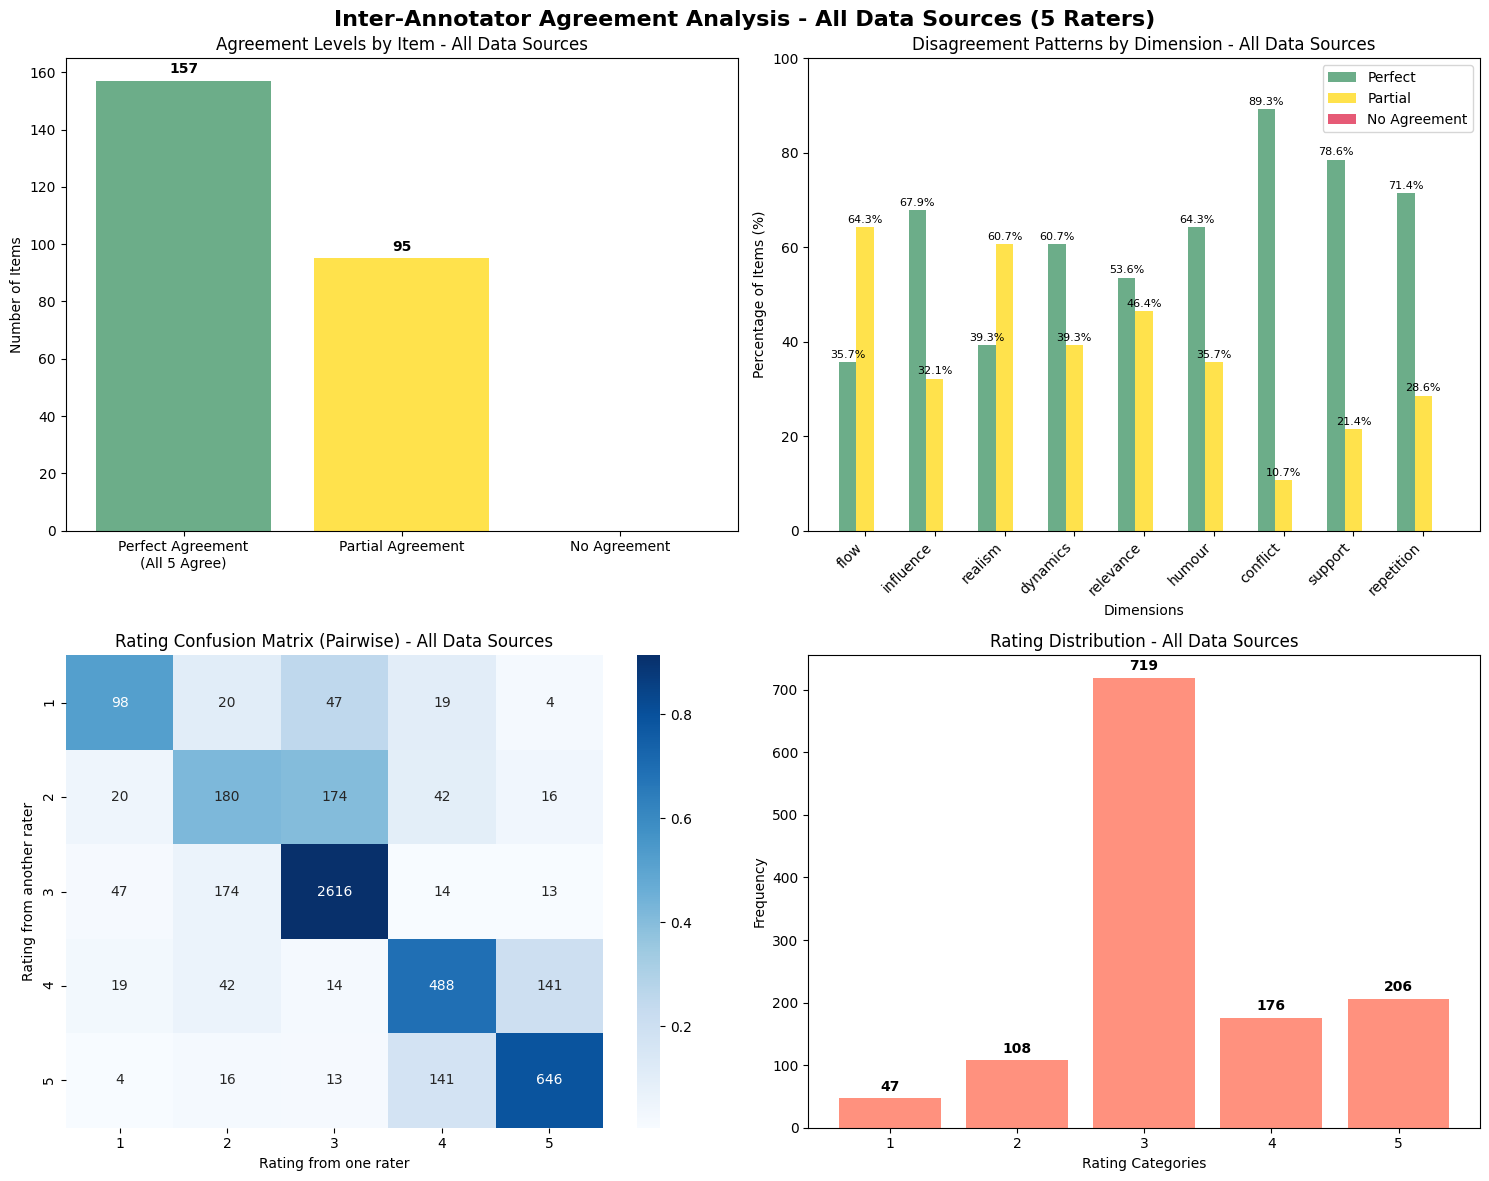


All Data Sources Summary:
Total items rated: 252
Perfect agreement items (all 5 raters agree): 157 (62.3%)
Partial agreement items: 95
No agreement items: 0
Total pairwise comparisons: 2504
Pairwise agreement rate: 2014/2504 (80.4%)
=== End of Analysis for All Data Sources ===



In [108]:
plot_agreement_analysis(merged, 'All Data Sources')

=== Agreement Analysis for Instagram ===
Number of raters: 5
Number of items: 63


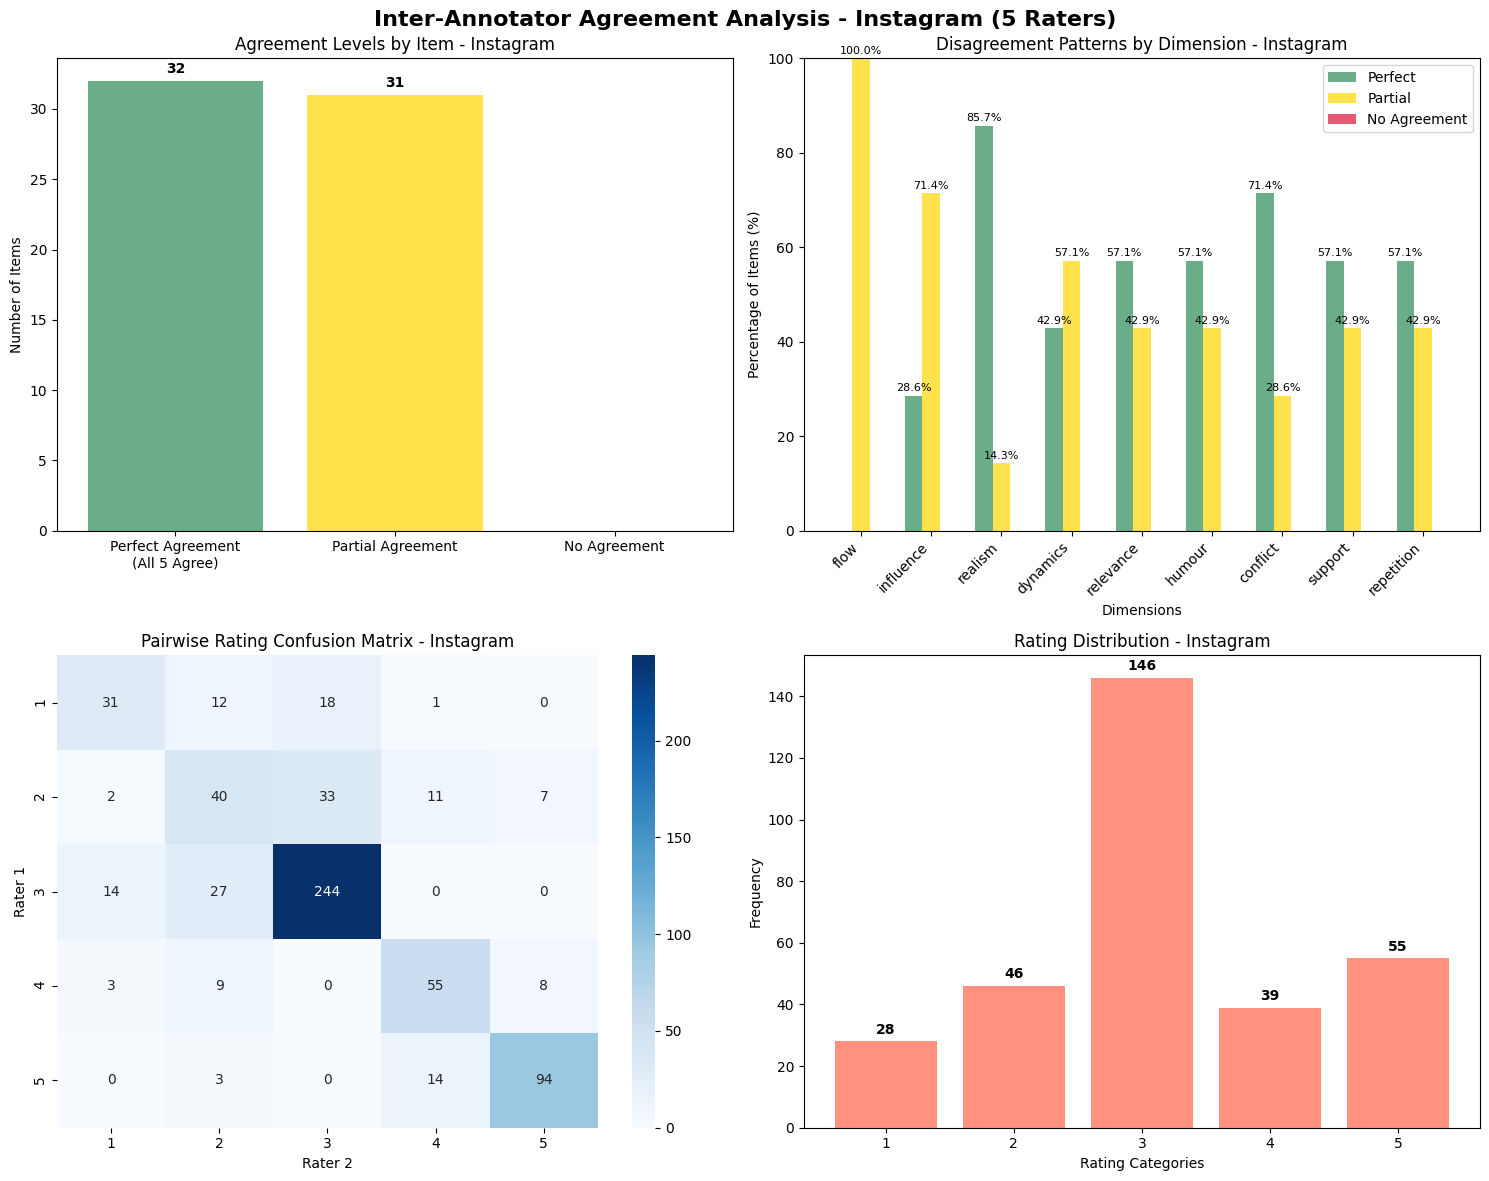


Instagram Summary:
Total items rated: 63
Perfect agreement items (all 5 raters agree): 32 (50.8%)
Partial agreement items: 31
No agreement items: 0
Total pairwise comparisons: 626
Pairwise agreement rate: 464/626 (74.1%)
=== End of Analysis for Instagram ===



In [97]:
plot_agreement_analysis(ig, 'Instagram')

In [101]:
def plot_multi_source_dimension_agreement(df_list, strategy_list):
    """
    Plot disagreement patterns by dimension as grouped bar charts for multiple data sources
    
    Parameters:
    df_list: List of DataFrames with numeric ratings (5 raters as rows, items as columns)
    strategy_list: List of strategy names corresponding to each DataFrame
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import combinations
    import pandas as pd
    
    # Likert value mapping
    likert_value_map = {
        # 5-point realism/relevance/flow etc.
        'Not relevant at all': 1,
        'Somewhat irrelevant': 2,
        'Neither relevant nor irrelevant': 3,
        'Somewhat relevant': 4,
        'Very relevant': 5,
        
        'Not realistic at all': 1,
        'Somewhat unrealistic': 2,
        'Neither realistic nor unrealistic': 3,
        'Somewhat realistic': 4,
        'Very realistic': 5,
        
        'Not at all easy to follow': 1,
        'Somewhat not easy to follow': 2,
        'Neither easy nor not easy to follow': 3,
        'Somewhat easy to follow': 4,
        'Very easy to follow': 5,
        # 3-point behavior dimensions
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # if there's trailing space in your data
    }
    
    def convert_dataframe_to_numeric(df, value_map=None):
        """Helper function to convert DataFrame to numeric values using provided mapping"""
        df_copy = df.copy()
        
        if value_map is None:
            # Default behavior - try to convert to numeric
            for col in df_copy.columns:
                df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        else:
            # Use provided mapping
            for col in df_copy.columns:
                if col != 'QID':  # Skip QID columns
                    df_copy[col] = df_copy[col].map(value_map).fillna(df_copy[col])
                    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        
        return df_copy
    
    # Create subplots - 2x2 grid for 4 data sources
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Inter-Annotator Agreement Analysis by Dimension - All Data Sources', 
                 fontsize=18, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Process each data source
    for idx, (df, strategy) in enumerate(zip(df_list, strategy_list)):
        ax = axes_flat[idx]
        
        # Convert to numeric using Likert mapping
        df_numeric = convert_dataframe_to_numeric(df, value_map=likert_value_map)
        df_numeric = df_numeric[[col for col in df_numeric.columns if 'QID' not in col]]
        
        # Extract dimensions
        dimensions = set()
        for col in df_numeric.columns:
            dimension = col.split('_')[-1]
            dimensions.add(dimension)
        
        dim_stats = {}
        for dim in dimensions:
            dim_cols = [col for col in df_numeric.columns if dim in col]
            dim_df = df_numeric[dim_cols]
            
            perfect_agreements = 0
            partial_agreements = 0
            no_agreements = 0
            total_items = 0
            
            for col in dim_df.columns:
                ratings = dim_df[col].dropna()
                if len(ratings) >= 2:
                    total_items += 1
                    unique_ratings = ratings.nunique()
                    
                    if unique_ratings == 1:
                        perfect_agreements += 1
                    else:
                        # Count pairwise agreements
                        pairs_agree = sum(1 for r1, r2 in combinations(ratings, 2) if r1 == r2)
                        
                        if pairs_agree > 0:
                            partial_agreements += 1
                        else:
                            no_agreements += 1
            
            if total_items > 0:
                perfect_pct = (perfect_agreements / total_items) * 100
                partial_pct = (partial_agreements / total_items) * 100
                no_agreement_pct = (no_agreements / total_items) * 100
                
                dim_stats[dim] = {
                    'Perfect': perfect_pct,
                    'Partial': partial_pct,
                    'No Agreement': no_agreement_pct
                }
        
        # Plot grouped bar chart
        if dim_stats:
            dims = list(dim_stats.keys())
            agreement_types = ['Perfect', 'Partial', 'No Agreement']
            colors = ['#2E8B57', '#FFD700', '#DC143C']
            
            x = np.arange(len(dims))
            width = 0.25
            
            for i, agreement_type in enumerate(agreement_types):
                values = [dim_stats[dim][agreement_type] for dim in dims]
                bars = ax.bar(x + i*width, values, width, label=agreement_type, 
                             color=colors[i], alpha=0.7)
                
                # Add value labels on bars
                for bar, value in zip(bars, values):
                    if value > 0:
                        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                               f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
            
            ax.set_title(f'{strategy}', fontsize=14, fontweight='bold')
            ax.set_ylabel('Percentage of Items (%)', fontsize=12)
            ax.set_xlabel('Dimensions', fontsize=12)
            ax.set_ylim(0, 110)
            ax.set_xticks(x + width)
            ax.set_xticklabels(dims, rotation=45, ha='right')
            ax.legend(fontsize=10)
            ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for all data sources
    print("=== Multi-Source Agreement Analysis Summary ===")
    for df, strategy in zip(df_list, strategy_list):
        df_numeric = convert_dataframe_to_numeric(df, value_map=likert_value_map)
        df_numeric = df_numeric[[col for col in df_numeric.columns if 'QID' not in col]]
        
        total_items = len([col for col in df_numeric.columns if not df_numeric[col].isna().all()])
        perfect_agreement_items = 0
        
        for col in df_numeric.columns:
            ratings = df_numeric[col].dropna()
            if len(ratings) >= 2 and ratings.nunique() == 1:
                perfect_agreement_items += 1
        
        perfect_agreement_rate = (perfect_agreement_items / total_items) * 100 if total_items > 0 else 0
        print(f"{strategy}: {total_items} items, {perfect_agreement_items} perfect agreements ({perfect_agreement_rate:.1f}%)")
    
    print("=== End of Multi-Source Analysis ===")


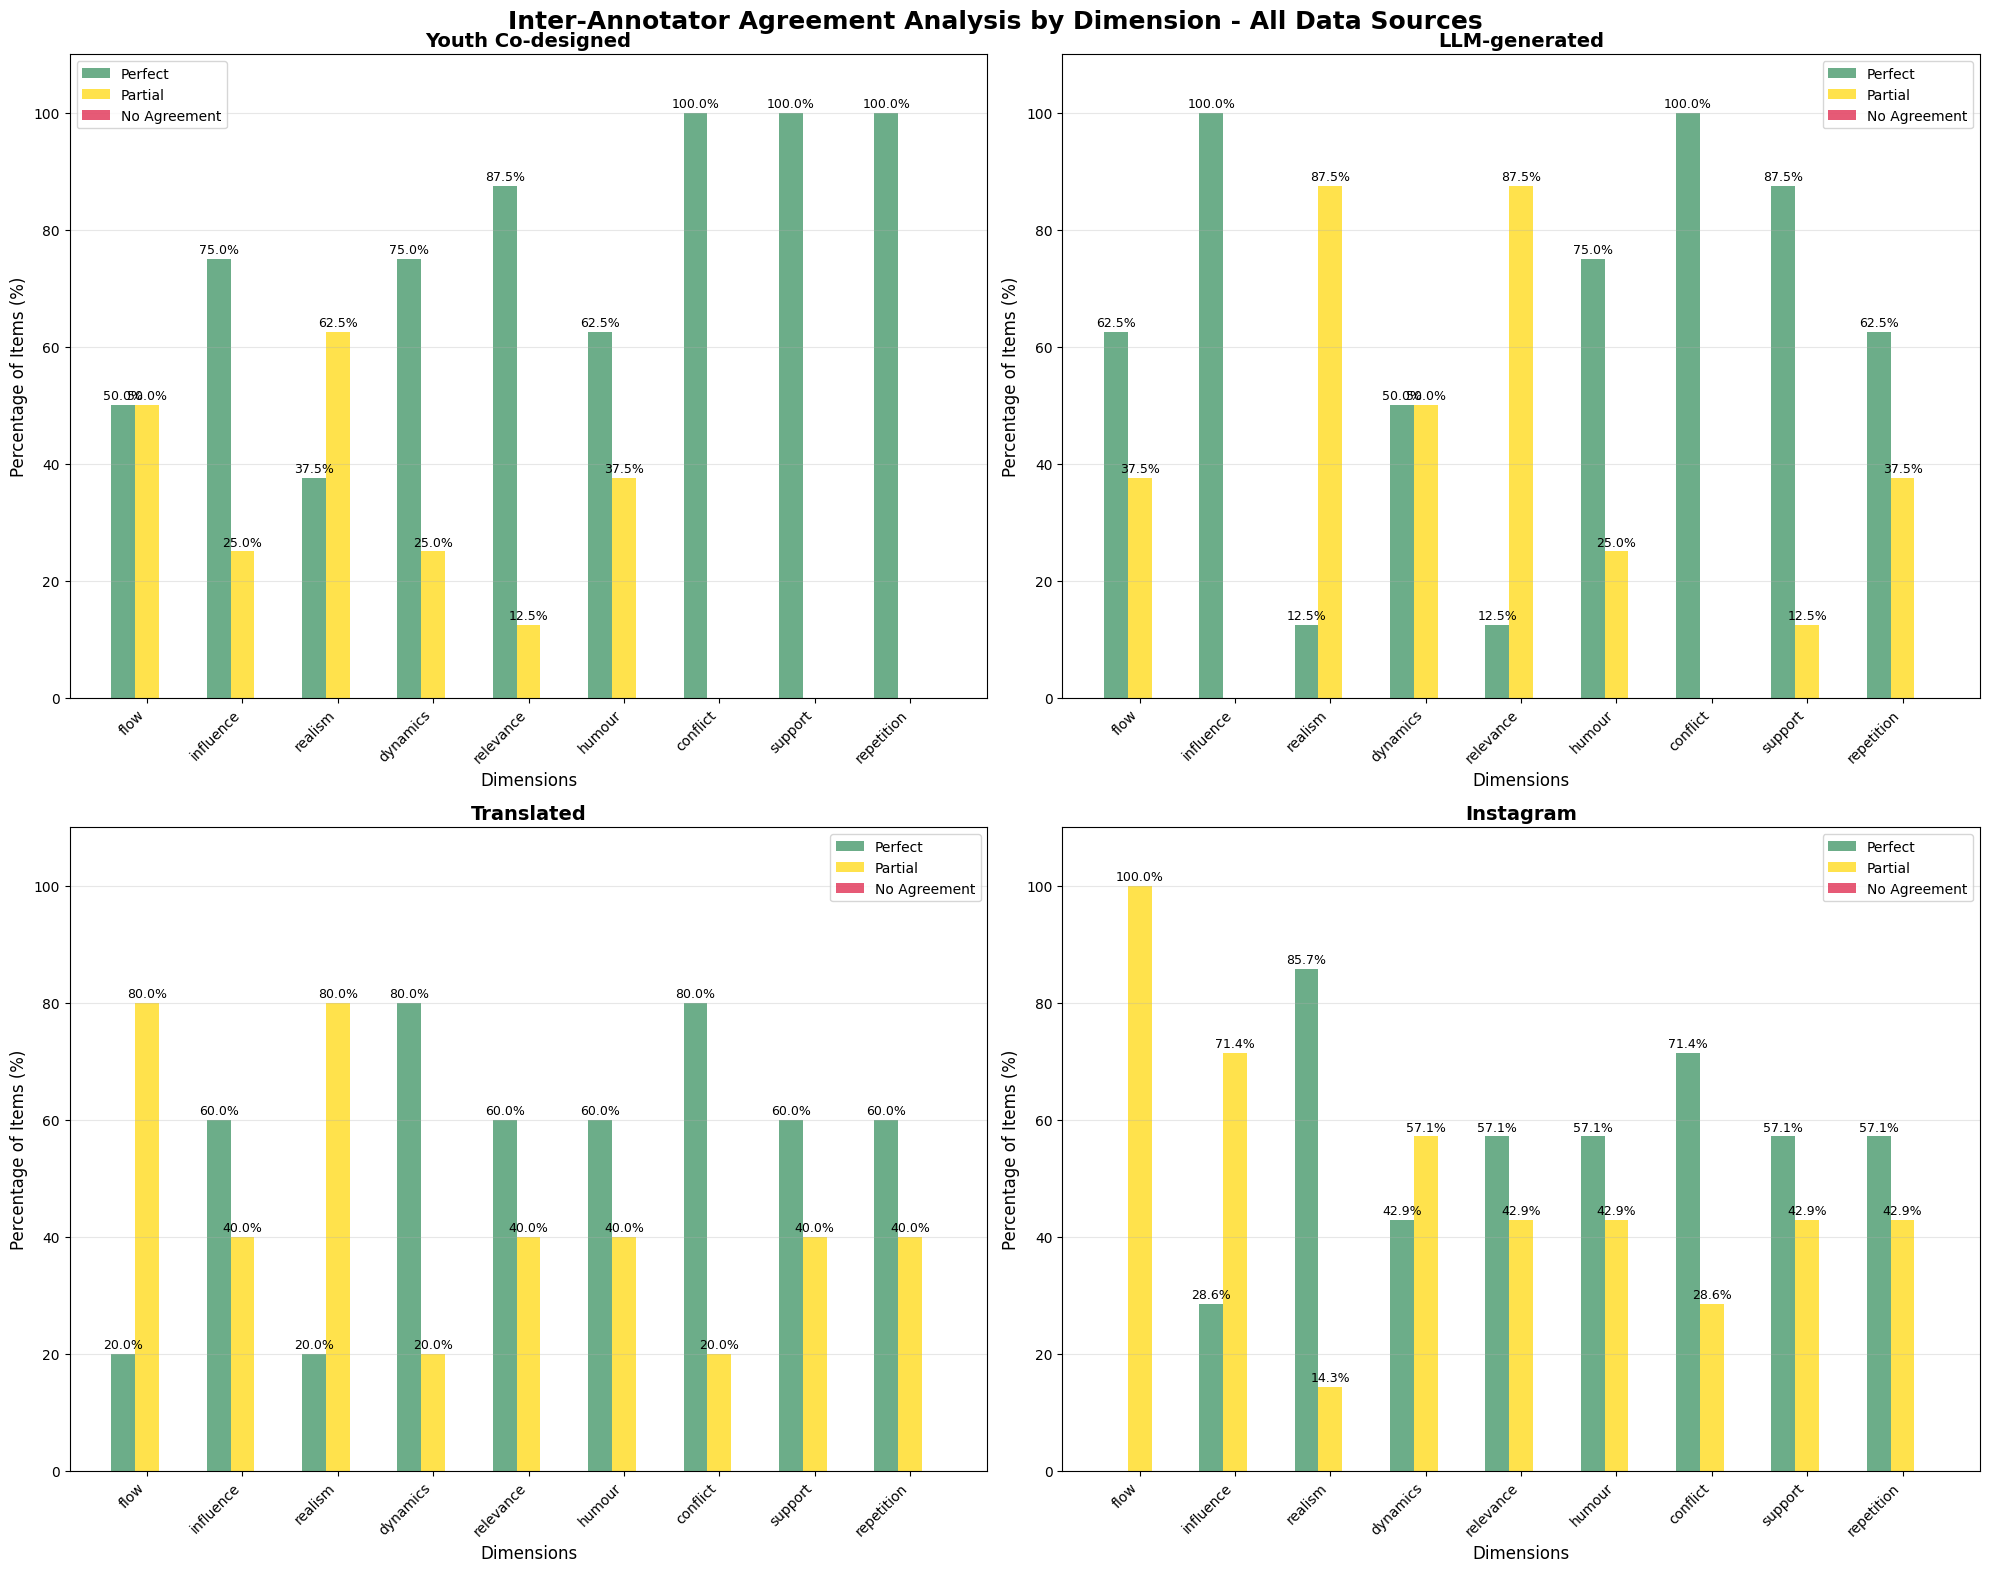

=== Multi-Source Agreement Analysis Summary ===
Youth Co-designed: 72 items, 55 perfect agreements (76.4%)
LLM-generated: 72 items, 45 perfect agreements (62.5%)
Translated: 45 items, 25 perfect agreements (55.6%)
Instagram: 63 items, 32 perfect agreements (50.8%)
=== End of Multi-Source Analysis ===


In [102]:

df_list = [ty, llm, tran, ig]

strategy_list = ['Youth Co-designed', 'LLM-generated', 'Translated', 'Instagram']

plot_multi_source_dimension_agreement(df_list, strategy_list)

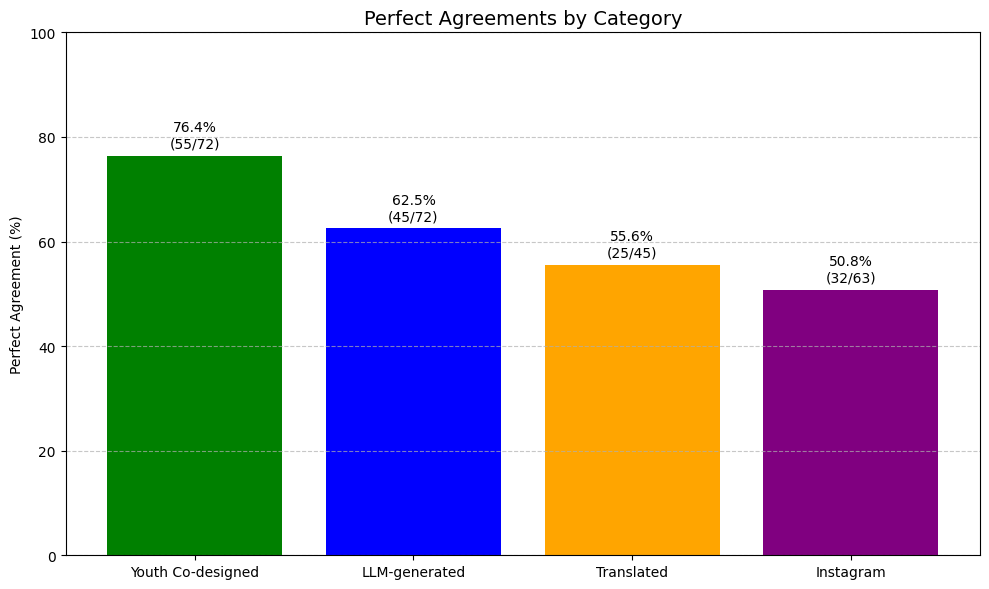

In [100]:
categories = ['Youth Co-designed', 'LLM-generated', 'Translated', 'Instagram']
items = [72, 72, 45, 63]
perfect_agreements = [55, 45, 25, 32]
percentages = [76.4, 62.5, 55.6, 50.8]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, percentages, color=['green', 'blue', 'orange', 'purple'])

# Add data labels
for bar, pct, pa, total in zip(bars, percentages, perfect_agreements, items):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{pct:.1f}%\n({pa}/{total})',
             ha='center', va='bottom', fontsize=10)

# Customize
plt.title('Perfect Agreements by Category', fontsize=14)
plt.ylabel('Perfect Agreement (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

def plot_pairwise_agreement_heatmaps_subplot(df, value_map=None, figsize=(15, 12)):
    """
    Plot 9 dimensions in a 3x3 subplot grid of pairwise inter-rater agreement heatmaps.
    
    Parameters:
    - df: DataFrame where rows = raters, columns = items
    - value_map: Optional mapping for Likert/string → numeric
    - figsize: Figure size tuple (width, height)
    """
    if value_map:
        df = df.applymap(lambda x: value_map.get(x, np.nan))
    
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    
    # Infer dimension names from column names
    dimensions = sorted(set(col.split('_')[-1] for col in df_numeric.columns))
    n_dims = len(dimensions)
    
    # Calculate grid size (for 9 dimensions, 3x3 is perfect)
    n_cols = 3
    n_rows = (n_dims + n_cols - 1) // n_cols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    axes_flat = axes.flatten()
    
    for idx, dim in enumerate(dimensions):
        ax = axes_flat[idx]
        
        # Get columns for this dimension
        dim_cols = [col for col in df_numeric.columns if col.endswith(dim)]
        dim_df = df_numeric[dim_cols]
        
        # Transpose: rows = items, cols = raters
        dim_df = dim_df.T
        rater_names = dim_df.columns
        n_raters = len(rater_names)
        
        # Compute pairwise agreement matrix
        agreement_matrix = np.zeros((n_raters, n_raters))
        for i in range(n_raters):
            for j in range(n_raters):
                if i == j:
                    agreement_matrix[i, j] = 1.0
                else:
                    # Compare ratings only where both raters have valid ratings
                    valid = dim_df[[rater_names[i], rater_names[j]]].dropna()
                    if len(valid) > 0:
                        agree = (valid[rater_names[i]] == valid[rater_names[j]]).sum()
                        total = len(valid)
                        agreement_matrix[i, j] = agree / total
                    else:
                        agreement_matrix[i, j] = np.nan  # no overlap
        
        # Plot heatmap on the current subplot
        sns.heatmap(
            agreement_matrix,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            xticklabels=[f"R{i+1}" for i in range(n_raters)],
            yticklabels=[f"R{i+1}" for i in range(n_raters)],
            vmin=0, vmax=1,
            linewidths=0.5, 
            linecolor='gray',
            ax=ax,
            cbar=False  # Disable individual colorbars
        )
        
        ax.set_title(f"Dimension: {dim}", fontsize=12)
        ax.set_xlabel("Rater", fontsize=10)
        ax.set_ylabel("Rater", fontsize=10)
    
    # Hide any unused subplots
    for idx in range(n_dims, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Add a single colorbar for all subplots
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Agreement Rate')
    
    plt.suptitle("Pairwise Rater Agreement Across All Dimensions", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Alternative: Flexible grid layout function
def plot_pairwise_agreement_flexible_grid(df, value_map=None, ncols=3, figsize=None):
    """
    Plot dimensions in a flexible grid layout.
    
    Parameters:
    - df: DataFrame where rows = raters, columns = items
    - value_map: Optional mapping for Likert/string → numeric
    - ncols: Number of columns in the grid
    - figsize: Figure size tuple (auto-calculated if None)
    """
    if value_map:
        df = df.applymap(lambda x: value_map.get(x, np.nan))
    
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    dimensions = sorted(set(col.split('_')[-1] for col in df_numeric.columns))
    n_dims = len(dimensions)
    
    nrows = (n_dims + ncols - 1) // ncols
    
    if figsize is None:
        figsize = (ncols * 4, nrows * 4)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if nrows == 1 and ncols == 1:
        axes = [axes]
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for idx, dim in enumerate(dimensions):
        ax = axes[idx]
        
        dim_cols = [col for col in df_numeric.columns if col.endswith(dim)]
        dim_df = df_numeric[dim_cols].T
        rater_names = dim_df.columns
        n_raters = len(rater_names)
        
        agreement_matrix = np.zeros((n_raters, n_raters))
        for i in range(n_raters):
            for j in range(n_raters):
                if i == j:
                    agreement_matrix[i, j] = 1.0
                else:
                    valid = dim_df[[rater_names[i], rater_names[j]]].dropna()
                    if len(valid) > 0:
                        agree = (valid[rater_names[i]] == valid[rater_names[j]]).sum()
                        total = len(valid)
                        agreement_matrix[i, j] = agree / total
                    else:
                        agreement_matrix[i, j] = np.nan
        
        sns.heatmap(
            agreement_matrix,
            annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=[f"R{i+1}" for i in range(n_raters)],
            yticklabels=[f"R{i+1}" for i in range(n_raters)],
            vmin=0, vmax=1, linewidths=0.5, linecolor='gray',
            ax=ax, cbar=False
        )
        
        ax.set_title(f"{dim}", fontsize=11)
        ax.set_xlabel("Rater", fontsize=9)
        ax.set_ylabel("Rater", fontsize=9)
    
    # Hide unused subplots
    for idx in range(n_dims, len(axes)):
        axes[idx].set_visible(False)
    
    # Add shared colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.02, 0.15, 0.02, 0.7])
    
    sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Agreement Rate')
    fig.subplots_adjust(left=0.1) 
    
    
    plt.suptitle("Pairwise Rater Agreement Across All Dimensions", fontsize=16)  
    plt.tight_layout(rect=[0.1, 0, 1, 0.95])
    plt.show()


/var/folders/y2/3kc8bf1n17g38nqcdc6f2d780000gn/T/ipykernel_3470/1034891269.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0, 1, 0.95])


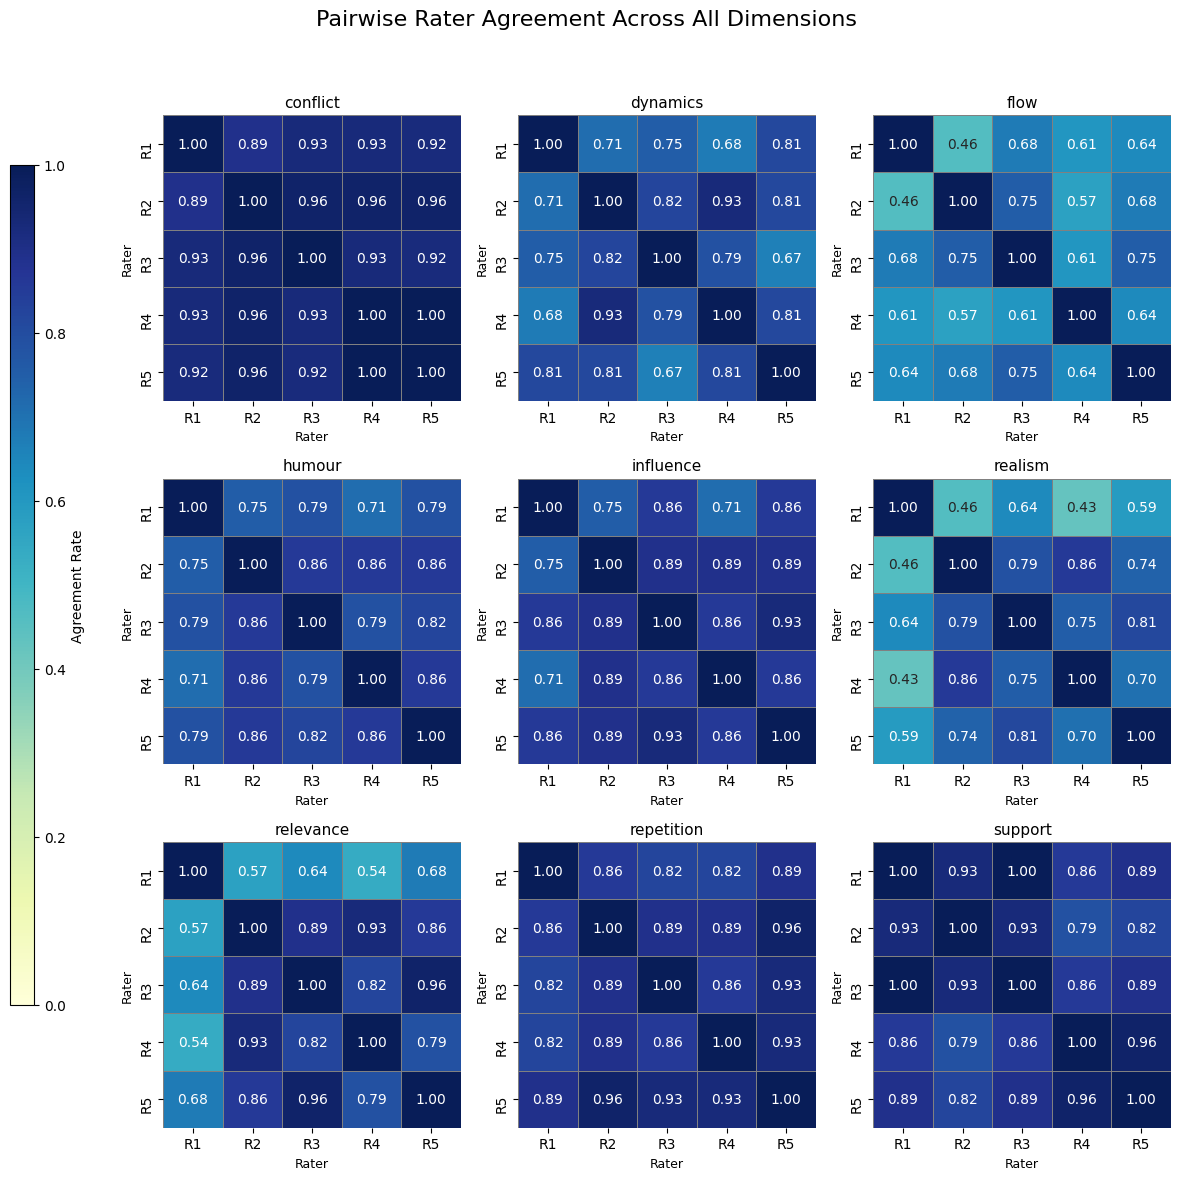

In [139]:
plot_pairwise_agreement_flexible_grid(merged[[cols for cols in merged.columns if 'QID' not in cols]], likert_value_map)


In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

def plot_agreement_by_rating_category(df, dimension_value_maps, figsize=(15, 12), ncols=3):
    """
    Plot agreement and disagreement counts by rating category for each dimension.
    
    Parameters:
    df: DataFrame with columns ending in dimension names
    dimension_value_maps: Dictionary mapping dimensions to their value mappings
    figsize: Figure size tuple
    ncols: Number of columns for subplot layout
    """
    # Create a copy to avoid modifying original data
    df_mapped = pd.DataFrame(index=df.index)

    # Apply correct value map per column
    for col in df.columns:
        # Extract dimension from column name (assumes format: prefix_dimension)
        if '_' in col:
            dim = col.split('_')[-1]
        else:
            dim = col.lower()  # fallback for columns without underscore
            
        value_map = dimension_value_maps.get(dim)
        if value_map:
            df_mapped[col] = df[col].map(value_map)
        else:
            # Keep original values if no mapping exists
            df_mapped[col] = df[col]
            print(f"Warning: No value map found for dimension '{dim}' in column '{col}'")

    # Get unique dimensions
    dimensions = []
    for col in df.columns:
        if '_' in col:
            dim = col.split('_')[-1]
        else:
            dim = col.lower()
        if dim not in dimensions:
            dimensions.append(dim)
    
    dimensions = sorted(dimensions)
    n_dims = len(dimensions)
    
    # Calculate grid layout
    nrows = (n_dims + ncols - 1) // ncols

    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle case where we have only one subplot
    if n_dims == 1:
        axes = [axes]
    else:
        axes = np.array(axes).reshape(-1)

    for idx, dim in enumerate(dimensions):
        ax = axes[idx]
        
        # Get columns for this dimension
        dim_cols = [col for col in df.columns if col.endswith(dim) or (not '_' in col and col.lower() == dim)]
        
        if not dim_cols:
            ax.set_visible(False)
            continue
            
        dim_df = df_mapped[dim_cols].T

        raters = dim_df.columns
        n_raters = len(raters)

        # Get unique ratings, handling NaN values
        all_values = dim_df.values.ravel()
        unique_ratings = sorted([r for r in pd.unique(all_values) if not pd.isna(r)])

        if not unique_ratings:
            ax.text(0.5, 0.5, f'No valid data for {dim}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Dimension: {dim}')
            continue

        agreement_per_cat = []
        disagreement_per_cat = []

        for rating in unique_ratings:
            total_agrees = 0
            total_disagrees = 0
            total_comparisons = 0
            
            # Compare all pairs of raters
            for i in range(n_raters):
                for j in range(i + 1, n_raters):
                    # Get valid (non-NaN) pairs for these two raters
                    rater1_data = dim_df.iloc[:, i]
                    rater2_data = dim_df.iloc[:, j]
                    
                    valid_mask = ~(pd.isna(rater1_data) | pd.isna(rater2_data))
                    
                    if not valid_mask.any():
                        continue
                    
                    valid_r1 = rater1_data[valid_mask]
                    valid_r2 = rater2_data[valid_mask]
                    
                    # Find cases where at least one rater gave this rating
                    rating_mask = (valid_r1 == rating) | (valid_r2 == rating)
                    
                    if not rating_mask.any():
                        continue
                    
                    # Count agreements and disagreements for this rating
                    both_agree = ((valid_r1 == rating) & (valid_r2 == rating))[rating_mask]
                    agrees = both_agree.sum()
                    total_for_rating = rating_mask.sum()
                    disagrees = total_for_rating - agrees
                    
                    total_agrees += agrees
                    total_disagrees += disagrees
                    total_comparisons += total_for_rating

            agreement_per_cat.append((total_agrees, total_comparisons))
            disagreement_per_cat.append((total_disagrees, total_comparisons))

        # Create reverse map for labeling
        value_map = dimension_value_maps.get(dim, {})
        if value_map:
            reverse_map = {v: ' '.join(k.split()[:2]) if isinstance(k, str) else str(k) 
                          for k, v in value_map.items()}
            labels = [reverse_map.get(r, str(r)) for r in unique_ratings]
        else:
            labels = [str(r) for r in unique_ratings]

        # Plotting
        x = np.arange(len(labels))
        width = 0.35

        agree_counts = [agrees for agrees, total in agreement_per_cat]
        disagree_counts = [disagrees for disagrees, total in disagreement_per_cat]

        bars1 = ax.bar(x - width/2, agree_counts, width, label='Agreement', color='lightgreen', alpha=0.8)
        bars2 = ax.bar(x + width/2, disagree_counts, width, label='Disagreement', color='lightcoral', alpha=0.8)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Set y-axis limit based on actual data
        max_count = max(max(agree_counts, default=0), max(disagree_counts, default=0))
        ax.set_ylim(0, max(max_count * 1.1, 10))  # 10% padding or minimum of 10
        
        ax.set_ylabel('Count')
        ax.set_title(f'Agreement by Rating - {dim.capitalize()}')
        ax.legend()

        # Add count annotations on bars
        for bars, counts_with_totals in [(bars1, agreement_per_cat), (bars2, disagreement_per_cat)]:
            for j, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0:  # Only annotate non-zero bars
                    agrees_or_disagrees, total = counts_with_totals[j]
                    ax.annotate(f'{int(height)}/{total}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3), textcoords="offset points",
                                ha='center', va='bottom', fontsize=8)

    # Hide unused subplots
    for i in range(n_dims, len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('Agreement and Disagreement Counts by Rating Category per Dimension', 
                 fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [181]:

# Define value maps per dimension
dimension_value_maps = {
    'relevance': {
        'Not relevant at all': 1,
        'Somewhat irrelevant': 2,
        'Neither relevant nor irrelevant': 3,
        'Somewhat relevant': 4,
        'Very relevant': 5,
    },
    'realism': {
        'Not realistic at all': 1,
        'Somewhat unrealistic': 2,
        'Neither realistic nor unrealistic': 3,
        'Somewhat realistic': 4,
        'Very realistic': 5,
    },
    'flow': {
        'Not at all easy to follow': 1,
        'Somewhat not easy to follow': 2,
        'Neither easy nor not easy to follow': 3,
        'Somewhat easy to follow': 4,
        'Very easy to follow': 5,
    },
    'conflict': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    },
    'dynamics': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    },
    'humour': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    },
    'influence': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    },
    'repetition': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    },
    'support': {
        'No - This behaviour is not present': 1,
        'Neutral - This behaviour is neither prominent nor absent.': 2,
        'Yes - This behaviour is noticeably present': 3,
        'Yes - This behaviour is noticeably present ': 3,  # trailing space variant
    }
}


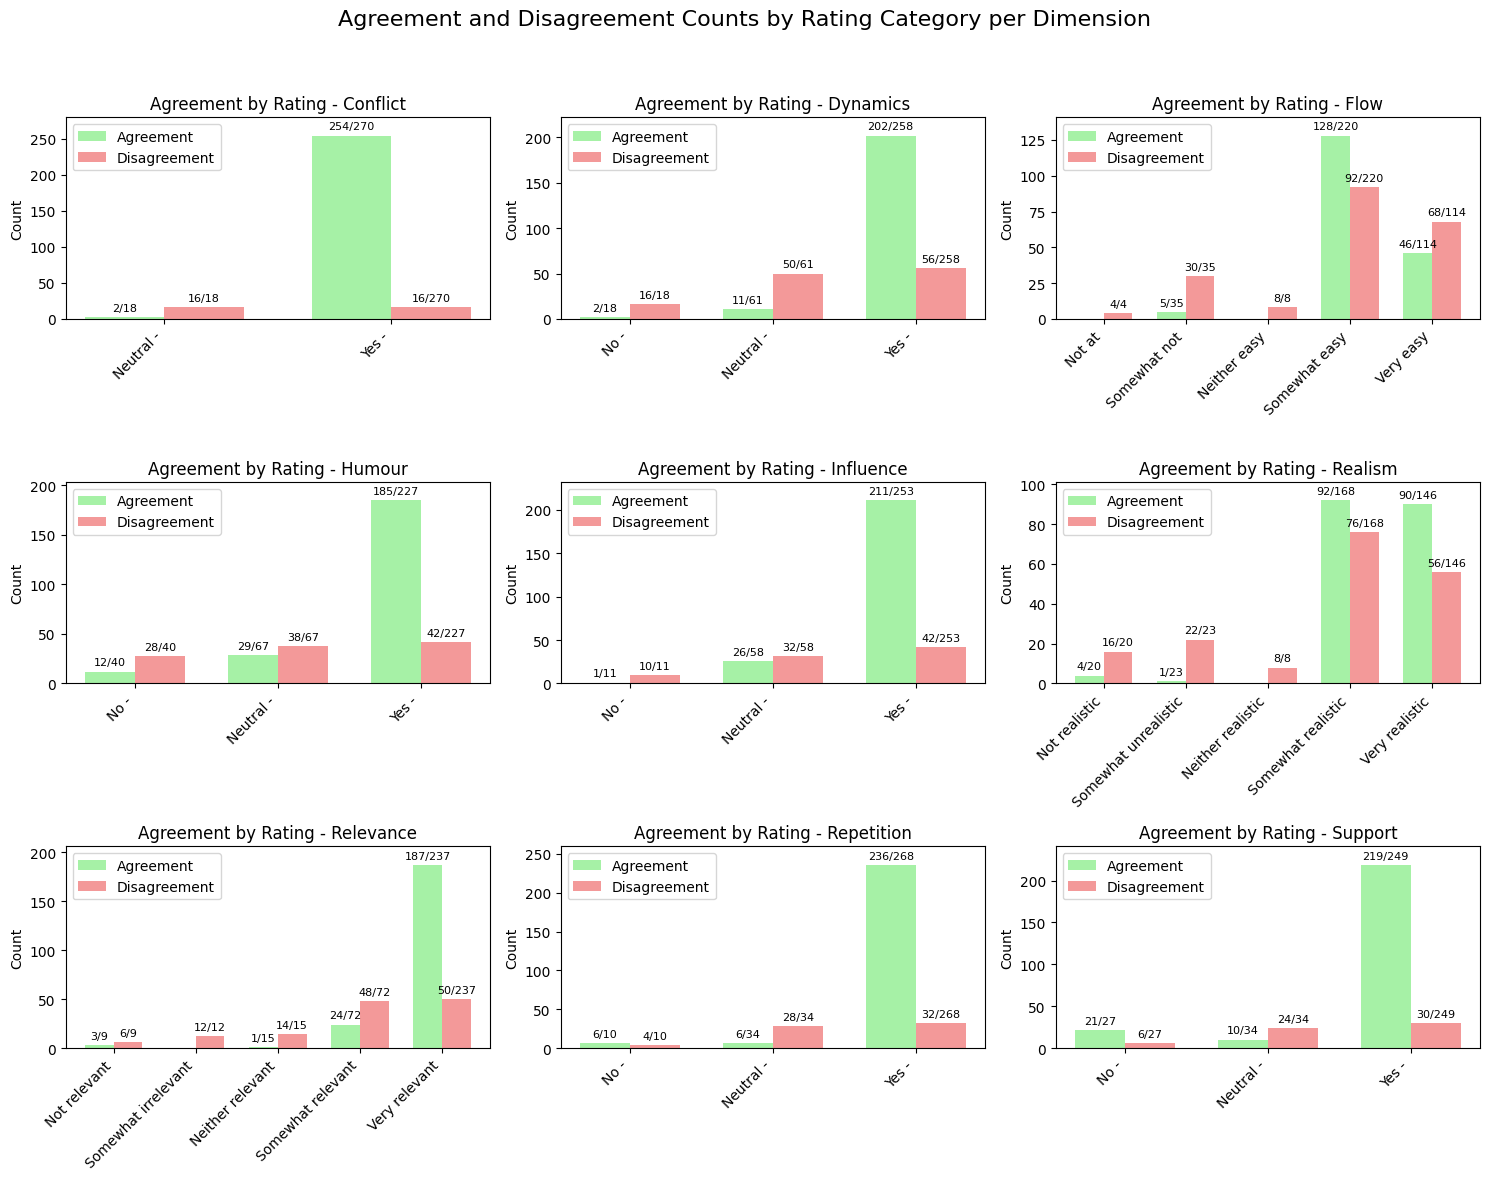

In [182]:
plot_agreement_by_rating_category(merged[[cols for cols in merged.columns if 'QID' not in cols]], dimension_value_maps)


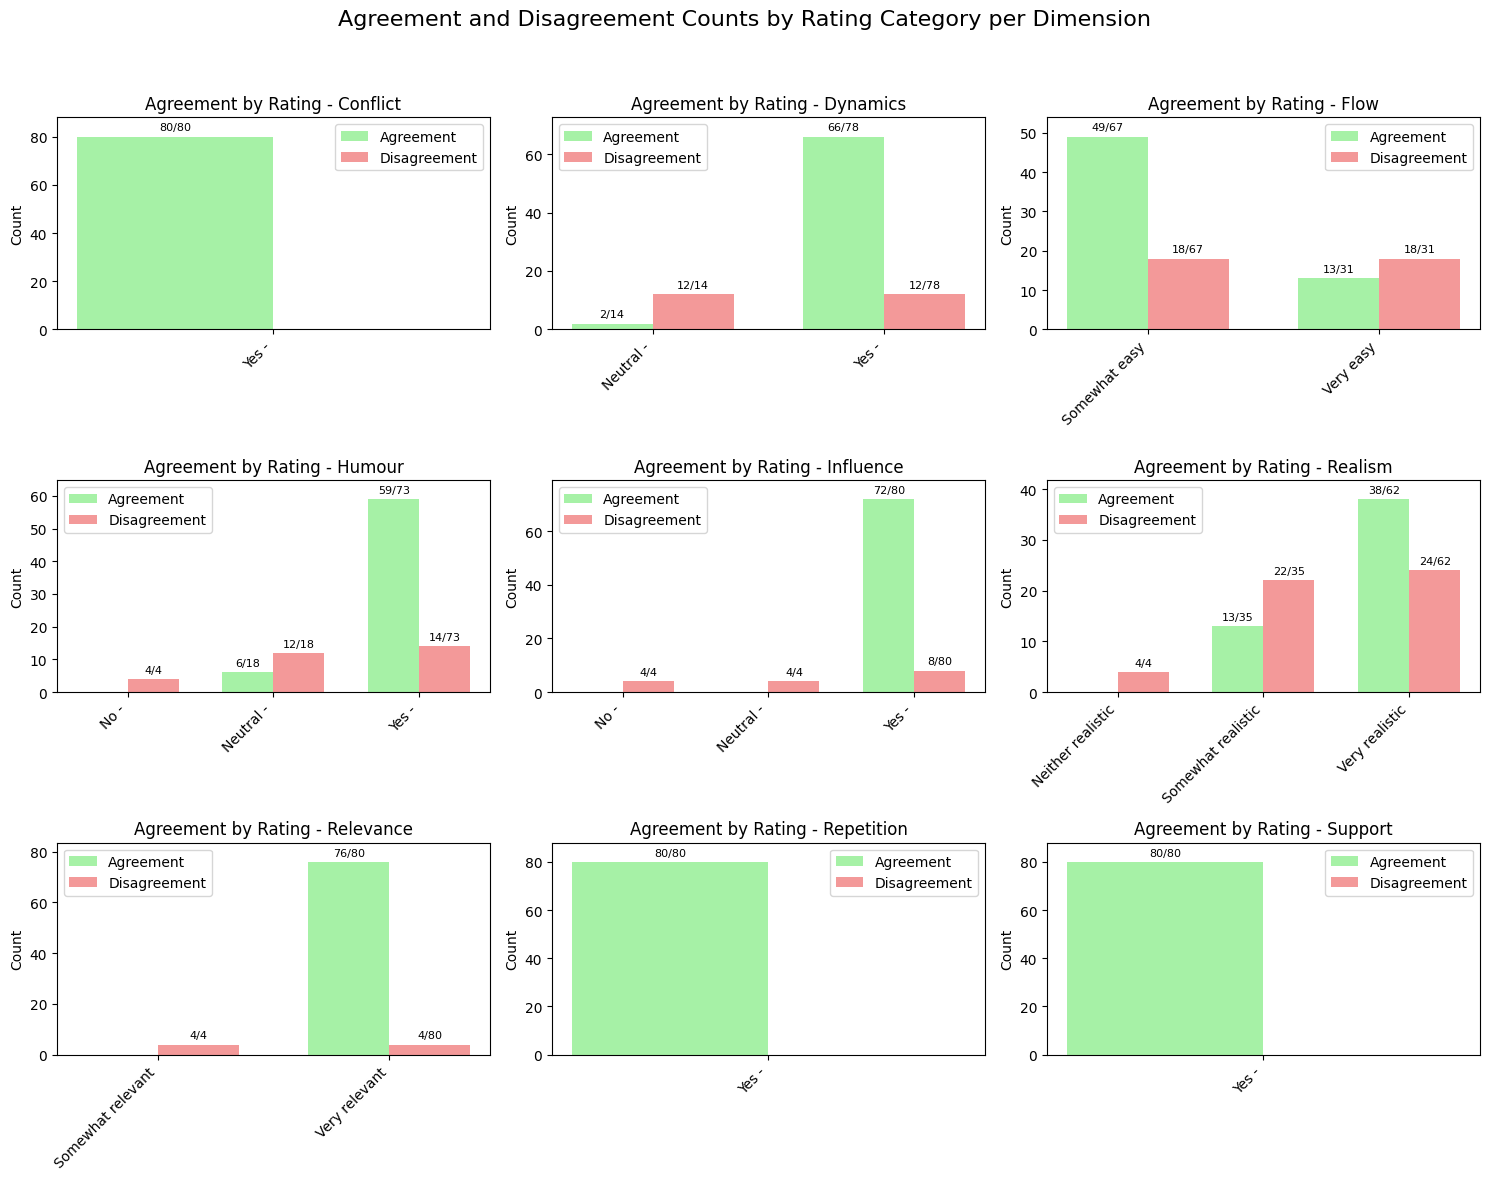

In [183]:
plot_agreement_by_rating_category(ty, dimension_value_maps)


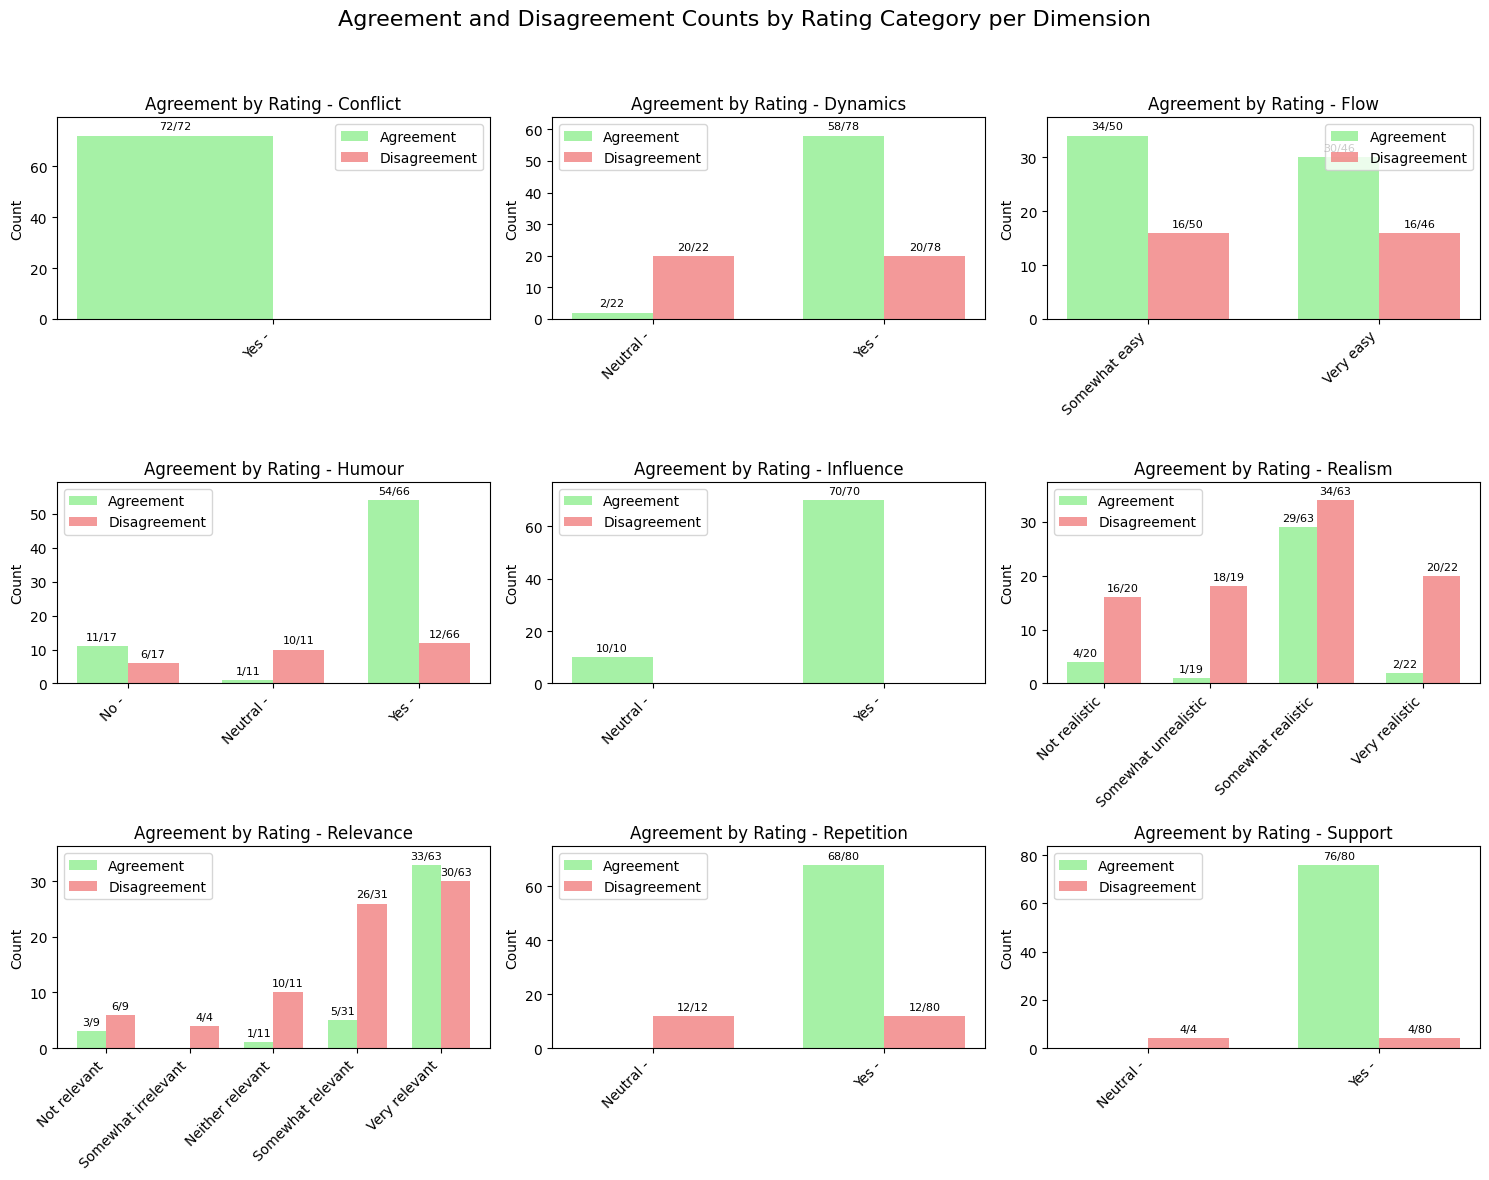

In [184]:
plot_agreement_by_rating_category(llm, dimension_value_maps)


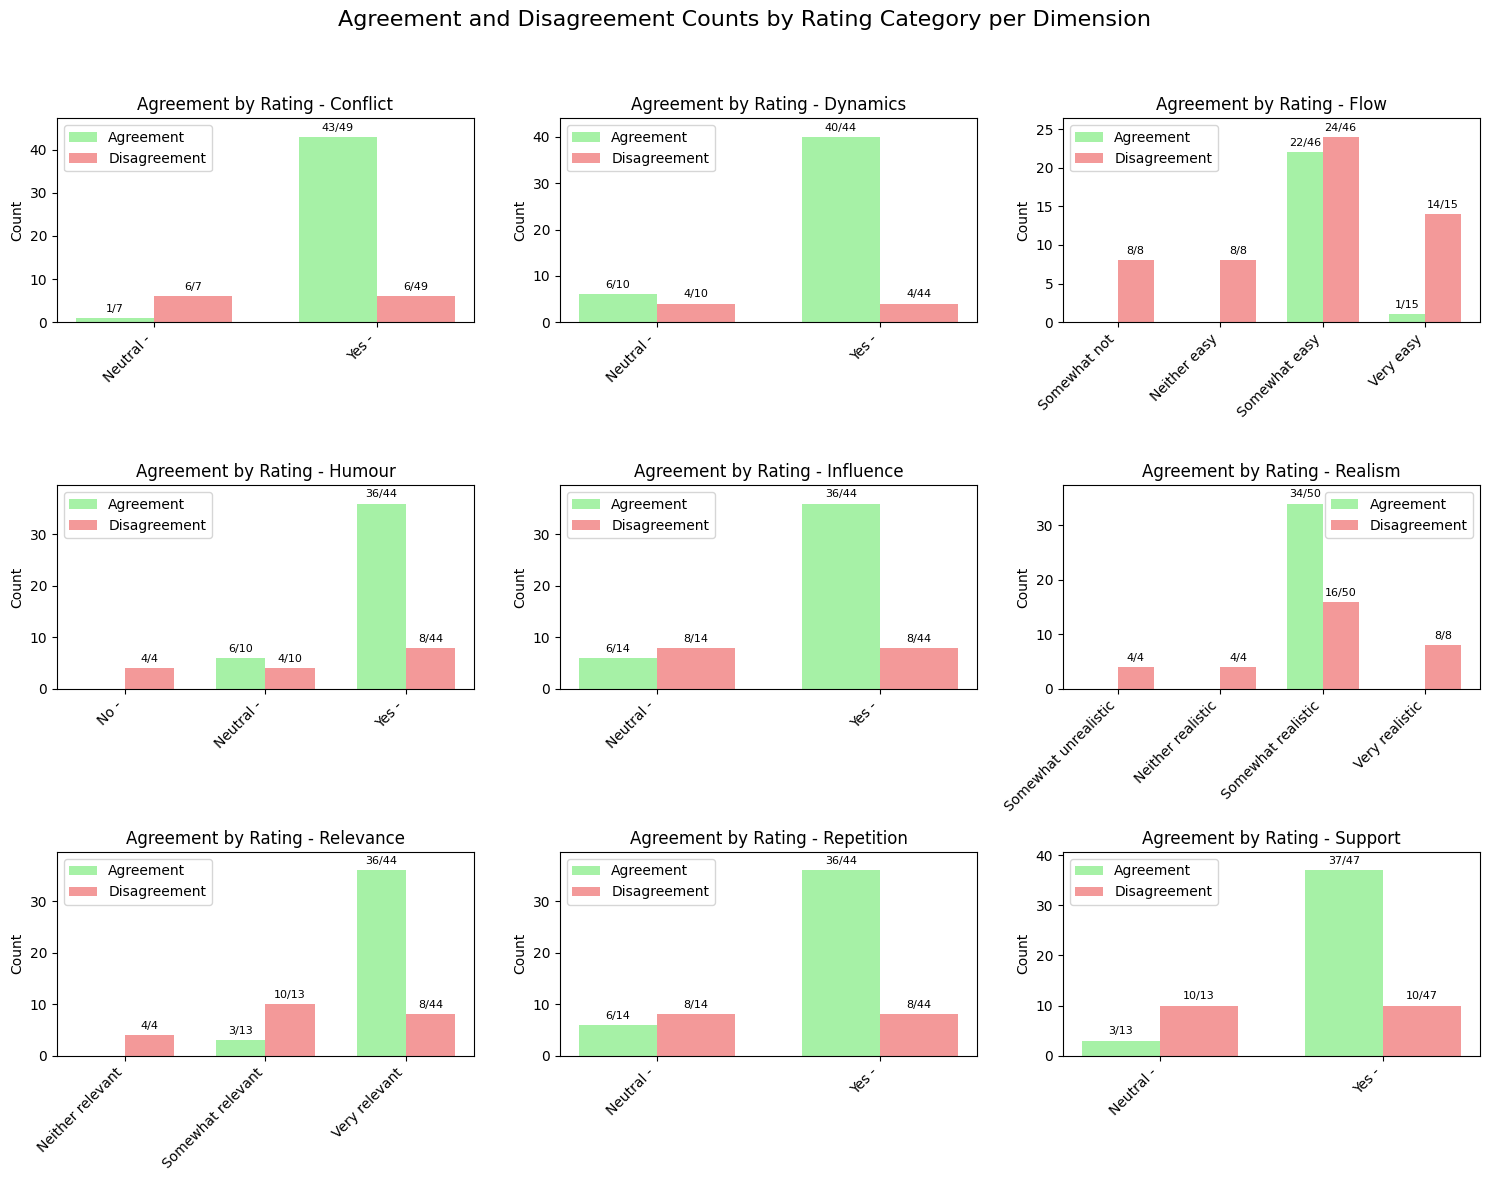

In [185]:
plot_agreement_by_rating_category(tran, dimension_value_maps)


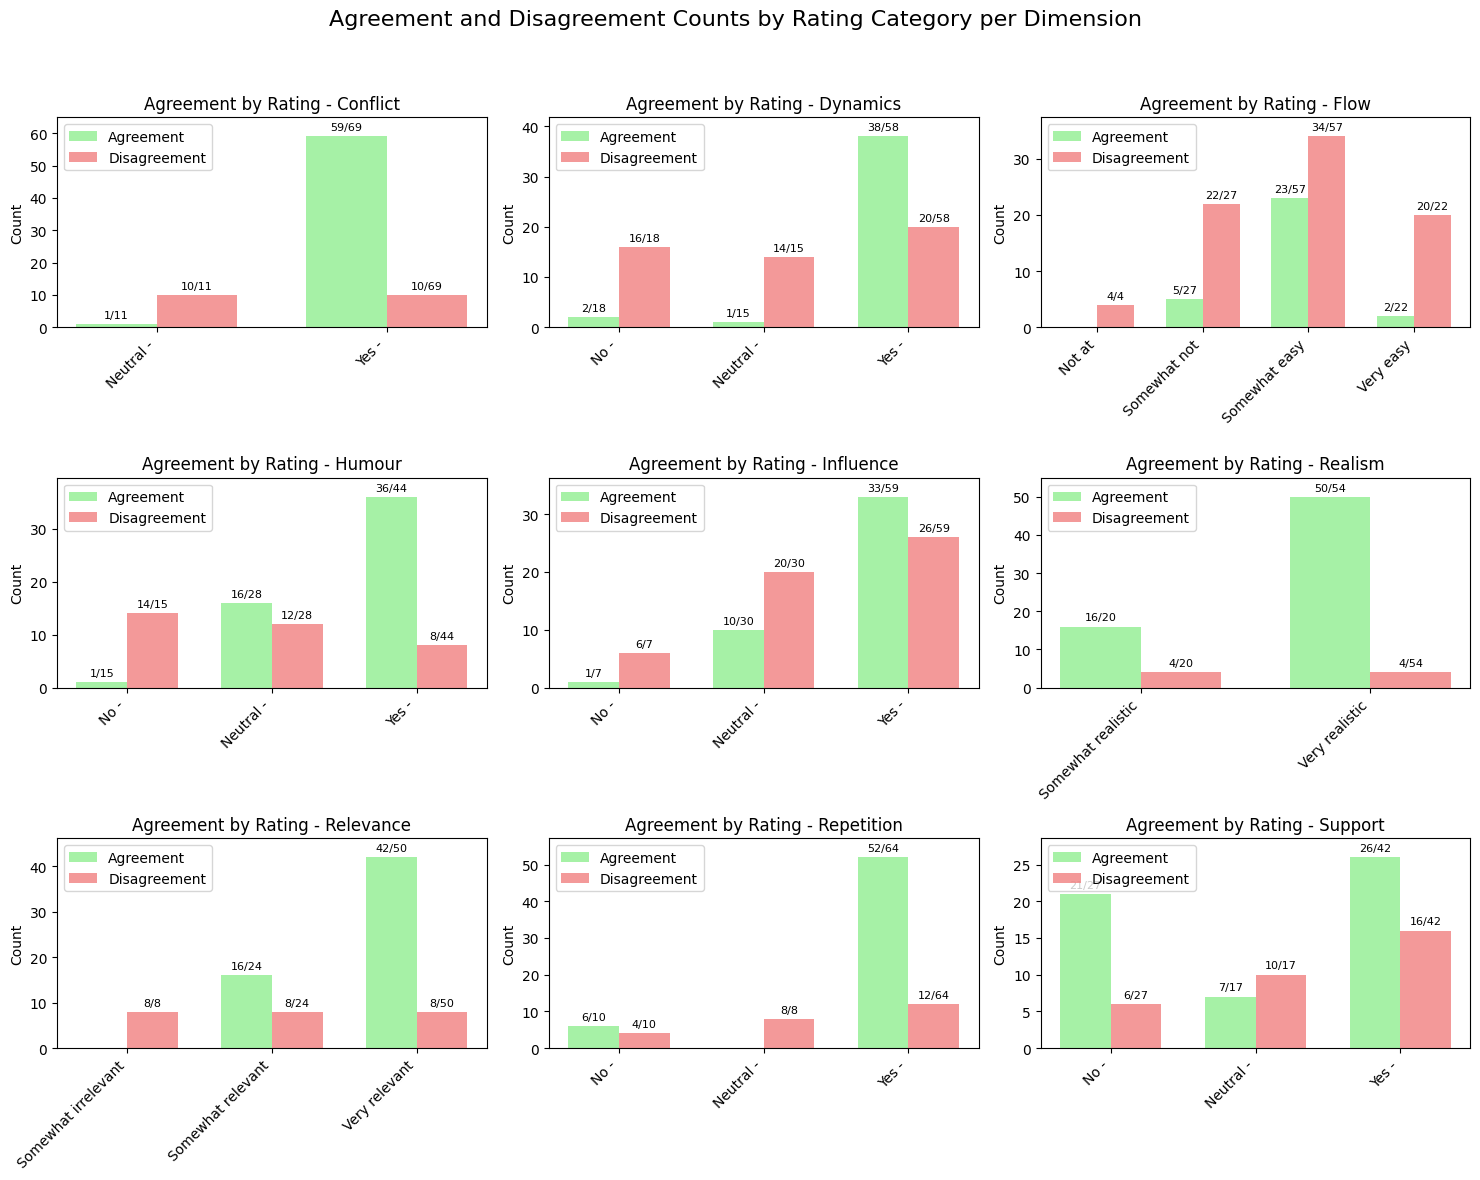

In [186]:
plot_agreement_by_rating_category(ig, dimension_value_maps)
